In [78]:
import os
import math 
import pywt
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq
from torch.utils.data import DataLoader, TensorDataset

In [79]:
def set_seed(seed: int = 42):
    random.seed(seed)                          # Python built-in random
    np.random.seed(seed)                       # NumPy random
    torch.manual_seed(seed)                    # CPU random seed
    torch.cuda.manual_seed(seed)               # GPU random seed (if used)
    torch.cuda.manual_seed_all(seed)           # All GPUs (if multiple GPUs)

    # Ensure deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Optional: for hash-based operations
    os.environ['PYTHONHASHSEED'] = str(seed)

In [80]:
set_seed(42)

# Load and shape synthetic test data
x = None
y = None

fs = 16

# load the data from synthetic data
data_folder = "./data/synthetic/test_3"
data_files = os.listdir(data_folder)
for file in data_files:
    if "samples_0" in file:
        if x is None and y is None:
            x = np.load(os.path.join(data_folder, file))
            y = np.zeros(5000)
        else:
            x = np.concatenate([x, np.load(os.path.join(data_folder, file))])
            y = np.concatenate([y, np.zeros(5000)])
    elif "samples_1" in file:
        if x is None and y is None:
            x = np.load(os.path.join(data_folder, file))
            y = np.ones(5000)
        else:
            x = np.concatenate([x, np.load(os.path.join(data_folder, file))])
            y = np.concatenate([y, np.ones(5000)])
    else:
        print("File not recognized")
        continue
    

x = x[:, np.newaxis, :]

print(x.shape)
print(y.shape)

# convert the data to torch tensors
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

# Shuffle indices once
indices = torch.randperm(len(x))

# Apply the shuffle
x_shuffled = x[indices]
y_shuffled = y[indices]

# create the dataset
dataset = TensorDataset(x_shuffled, y_shuffled)

# create the DataLoader
test_loader = DataLoader(dataset, batch_size=128)

(10000, 1, 16)
(10000,)


In [81]:
signals_0 = []
signals_1 = []

for batch in test_loader:
    x, y = batch

    for i in range(0, len(x)):
        if y[i] == 0:
            signals_0.append(x[i, 0, :].numpy())
        else:
            signals_1.append(x[i, 0, :].numpy())
        
        if i == 9:
            break
    break

signals_0 = np.array(signals_0)
signals_1 = np.array(signals_1)

print(signals_0.shape)
print(signals_1.shape)

(6, 16)
(4, 16)


In [82]:
def plot_fft(signal, fs):
    N = len(signal)
    T = 1.0 / fs
    yf = fft(signal)
    xf = fftfreq(N, T)[:N//2]
    
    plt.figure(figsize=(10, 4))
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    plt.title("FFT")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.show()

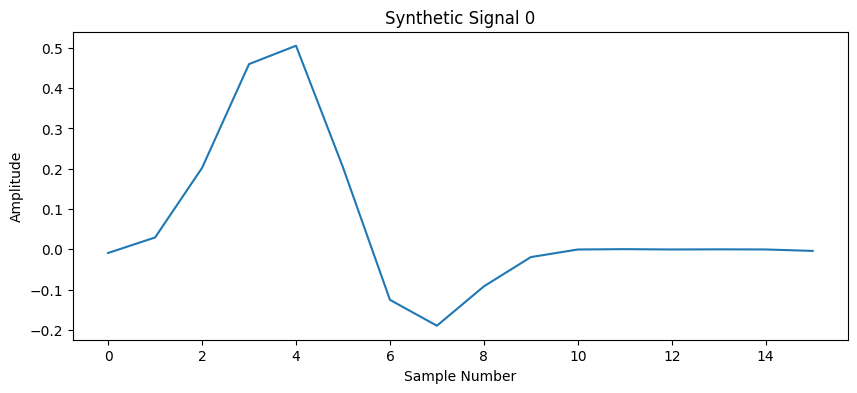

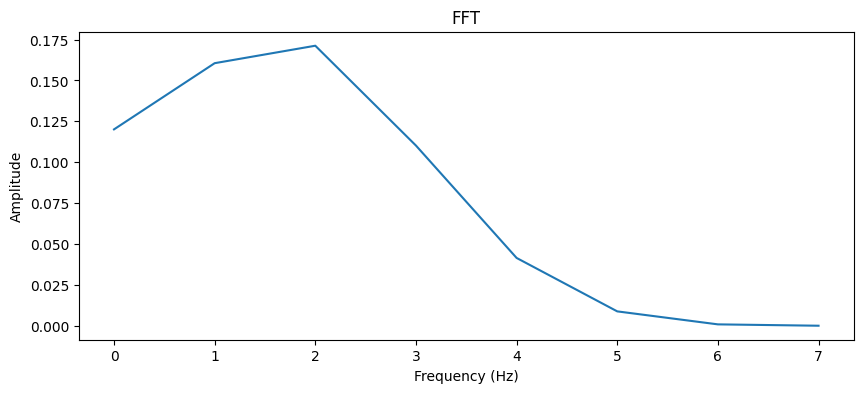

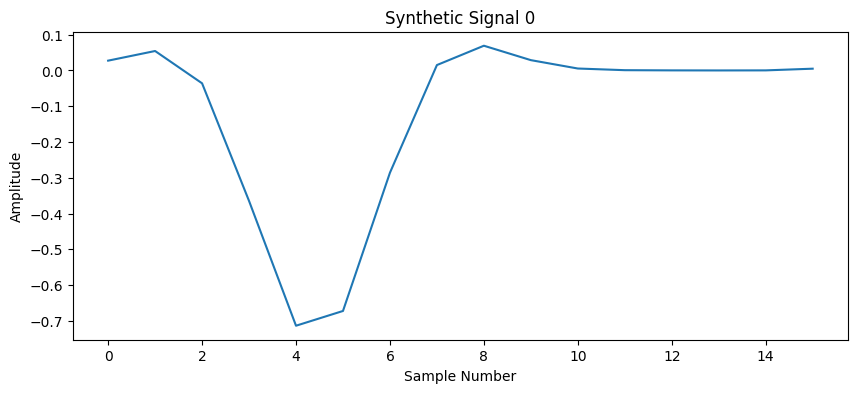

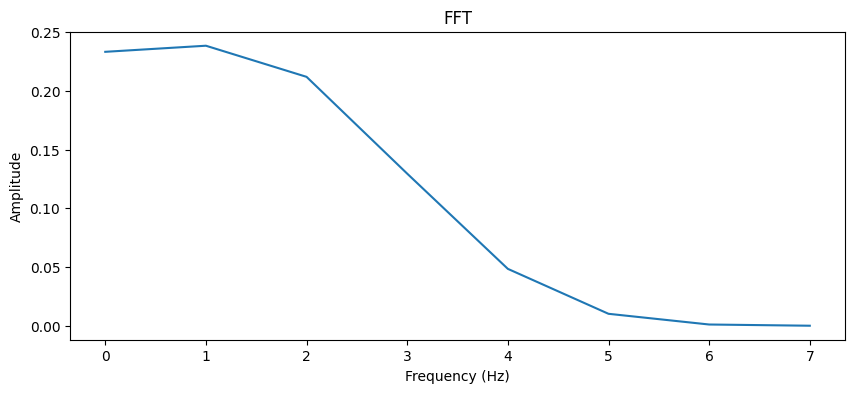

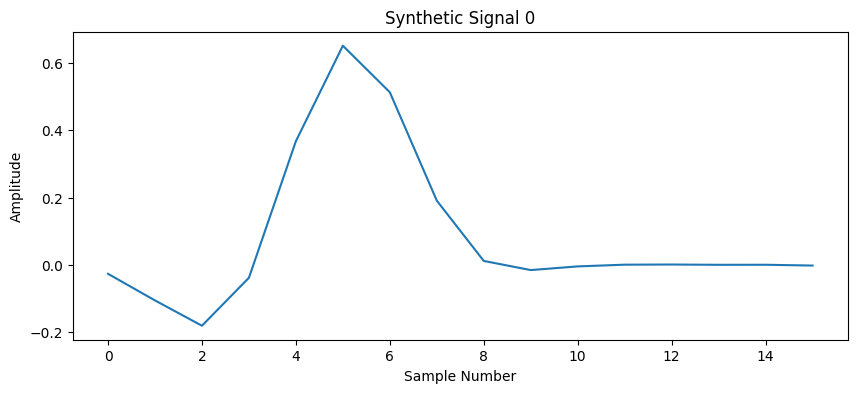

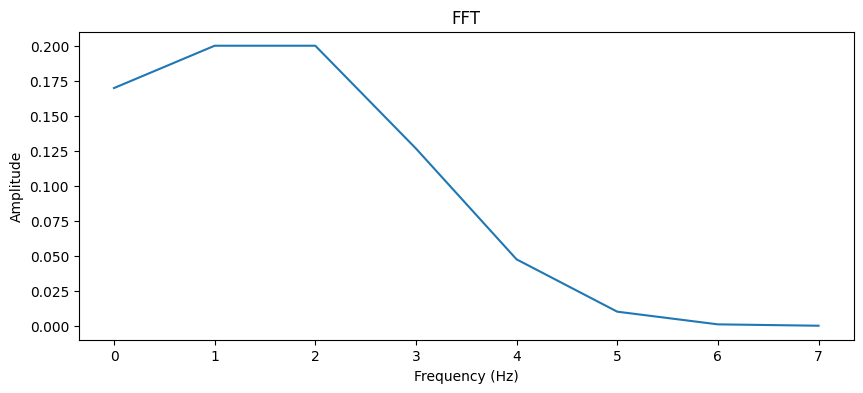

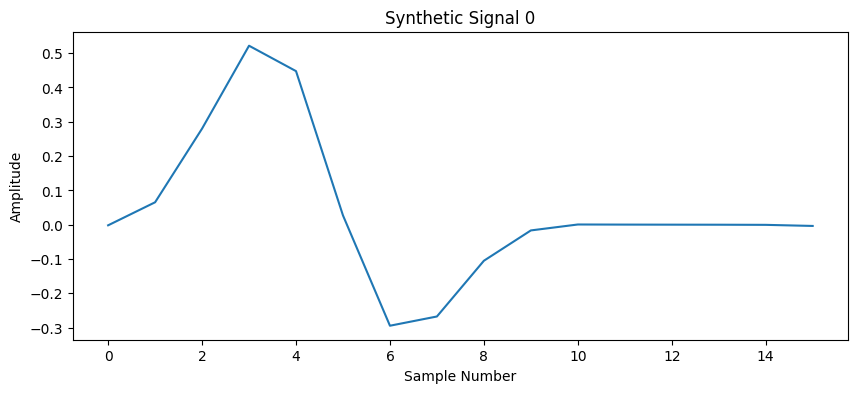

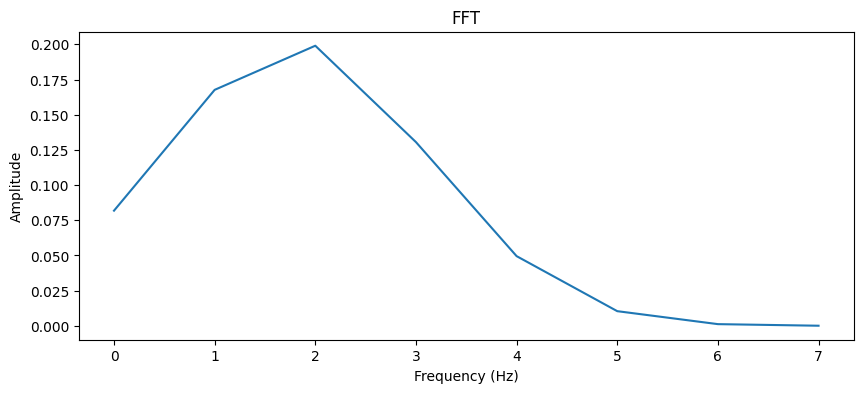

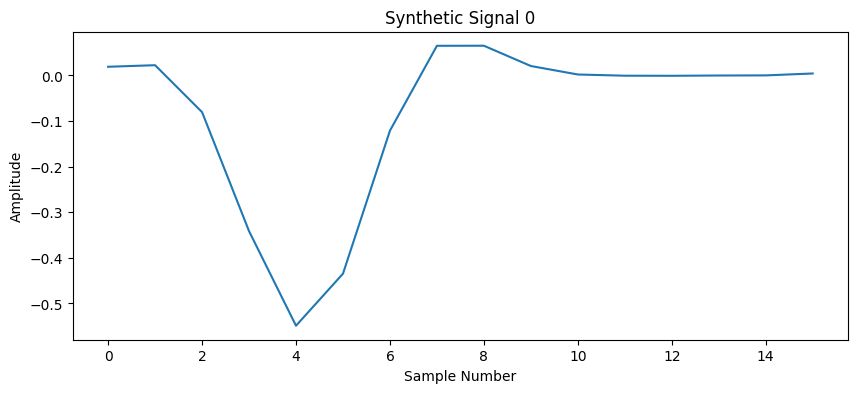

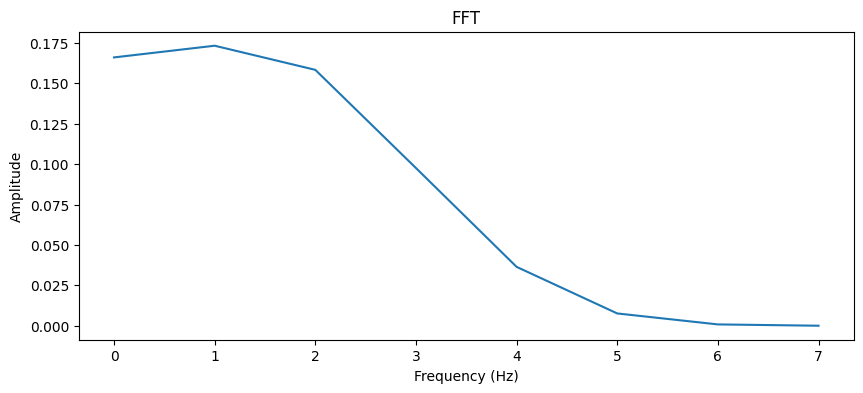

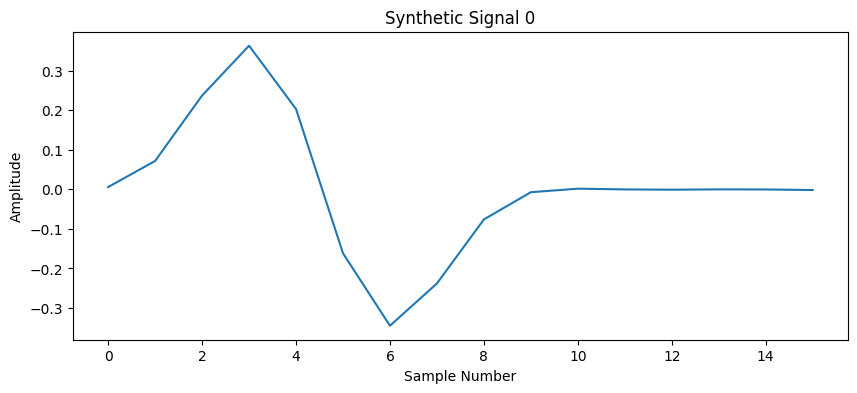

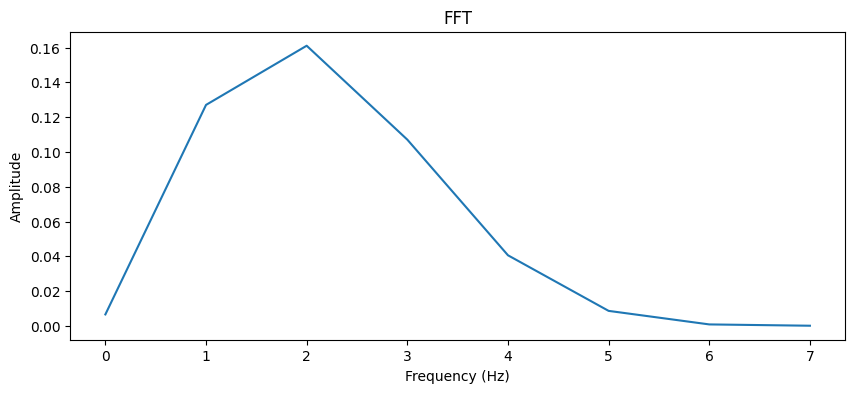

In [83]:
# plot the signal
for signal_0 in signals_0:
    plt.figure(figsize=(10, 4))
    plt.plot(signal_0)
    plt.title('Synthetic Signal 0')
    plt.xlabel('Sample Number')
    plt.ylabel('Amplitude')
    plt.show()

    # plot the fft of the signal
    plot_fft(signal_0, fs)

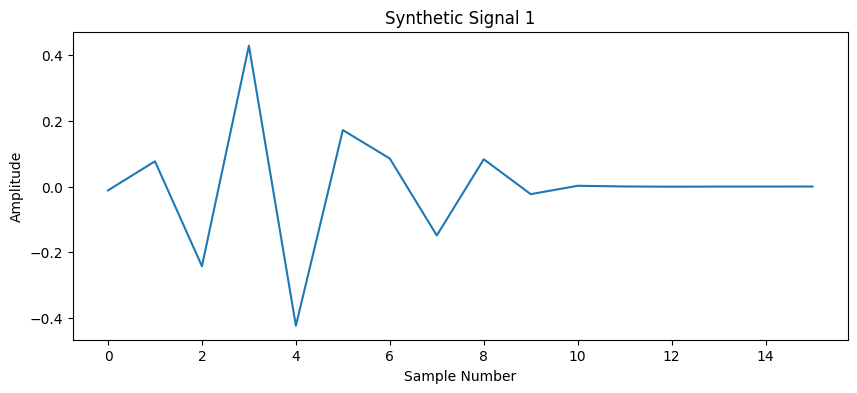

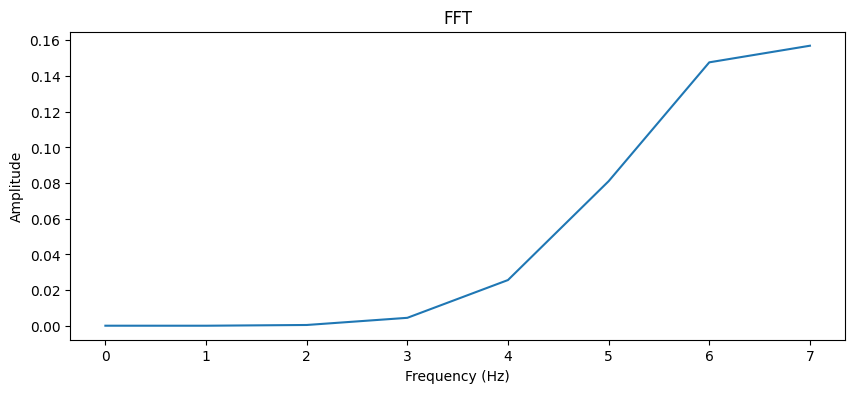

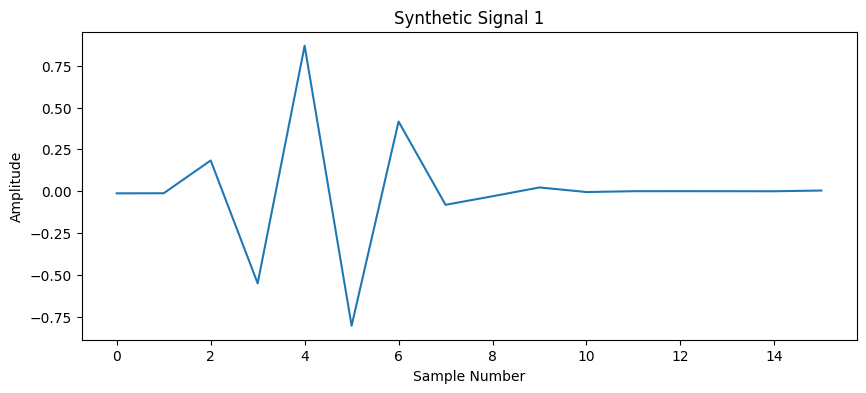

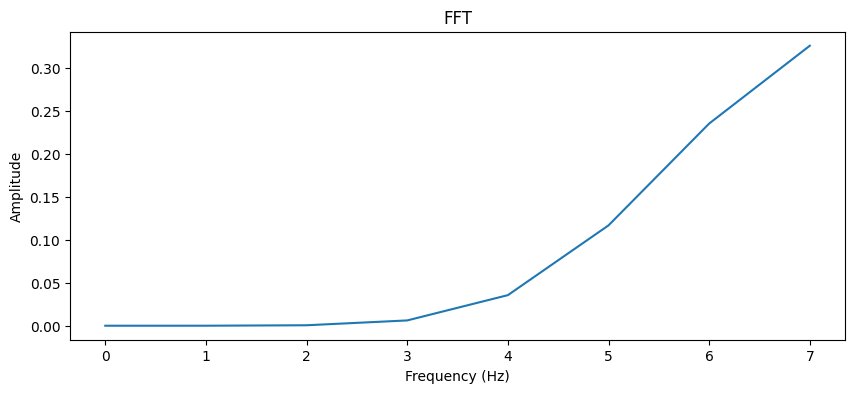

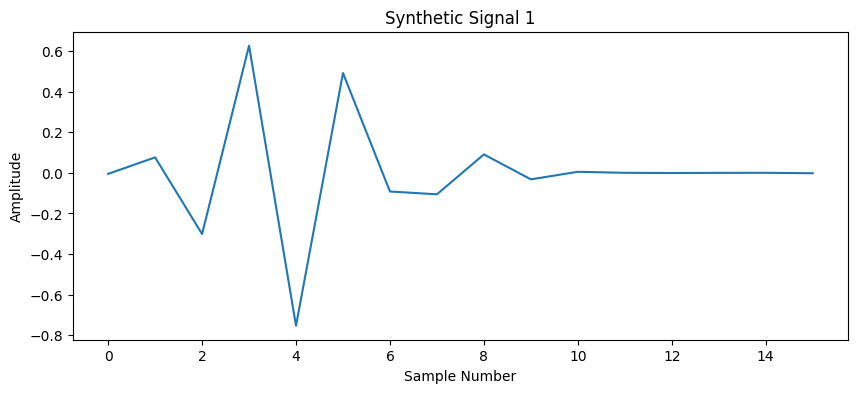

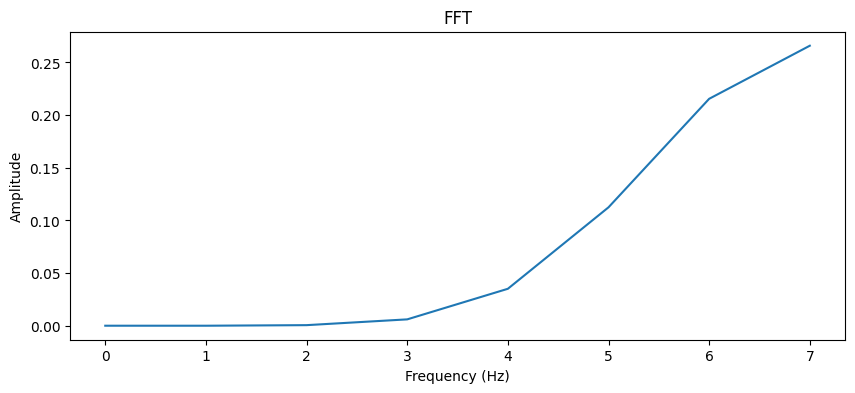

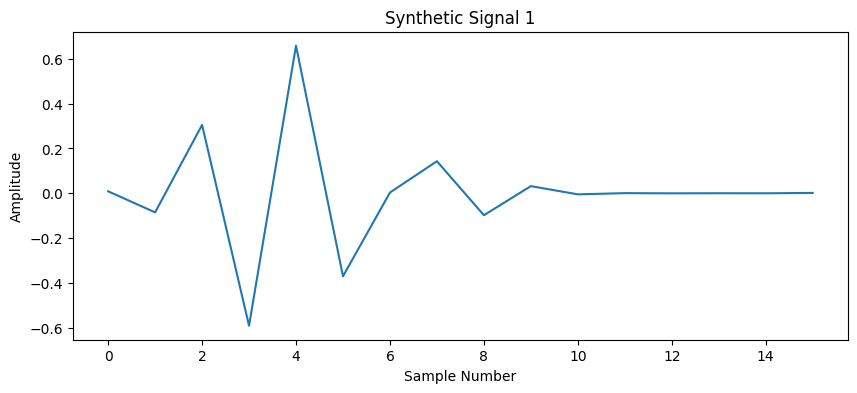

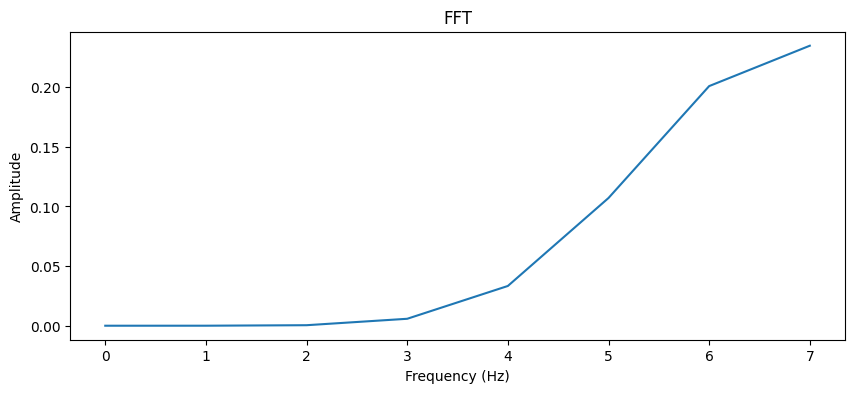

In [84]:
# plot the signal
for signal_1 in signals_1:
    plt.figure(figsize=(10, 4))
    plt.plot(signal_1)
    plt.title('Synthetic Signal 1')
    plt.xlabel('Sample Number')
    plt.ylabel('Amplitude')
    plt.show()

    # plot the fft of the signal
    plot_fft(signal_1, fs)


In [102]:
# perfrorm multiscale wavelet transform
# get max level for the multiscale wavelet transform
max_level = pywt.dwt_max_level(len(signal_1), 'db1')
print(f"Max level: {max_level}")

coeffs_0 = []
for signal_0 in signals_0:
    coeffs_0.append(pywt.wavedec(signal_0, 'db1', level=max_level))

coeffs_1 = []
for signal_1 in signals_1:
    coeffs_1.append(pywt.wavedec(signal_1, 'db1', level=max_level))


print(f"Length of coefs_1: {len(coeffs_0)}")
print(f"Length of coefs_2: {len(coeffs_1)}")


Max level: 4
Length of coefs_1: 6
Length of coefs_2: 4


In [148]:
# print the scaloegram
def plot_dwt_scaleogram_freq(fs, coeffs, level, time, data, normalize=False, rescale=False):
        """
        Plot the scaleogram of the Discrete Wavelet Transform (DWT).
        """
        title = "DWT Scaleogram "

        # Compute frequency bands
        freq_bands = [fs /  (2 ** (j + 1)) for j in range(level)]   # bands
        freq_bands.append(0)                                        # lowest frequency

        # flip the frequency bands
        freq_bands = freq_bands[::-1]

        # Prepare the scaleogram
        scaleogram = []
        for i, coeff in enumerate(coeffs):
            factor = math.ceil(len(data)/len(coeff))
            # convert to power and normalize db
            # coeff = np.abs(coeff) ** 2

            if rescale:
                # multiply each level by 2 to the power of i to rescale
                level = max(0, i-1)
                coeff = coeff * (2 ** level)

            # Upsample coefficients to match the original signal length
            upsampled = np.repeat(coeff, factor)[:len(data)]
            
            scaleogram.append(upsampled)
        scaleogram = np.array(scaleogram)
        scaleogram = scaleogram[1:, :]

        # normalize the scaleogram
        scaleogram = (scaleogram - np.min(scaleogram)) / (np.max(scaleogram) - np.min(scaleogram) + 1e-10)
        if normalize:
            title += 'normalized '
        elif rescale:
            title += 'rescaled'

        # add an extra element to the time nd array
        time_s = np.concatenate([time, [time[-1] + (1/fs)]])
    

        # Plot the scaleogram
        plt.figure(figsize=(10, 4))
        plt.pcolormesh(time_s, freq_bands, np.abs(scaleogram), cmap='viridis')
        plt.colorbar(label='Amplitude')
        plt.title(title)
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (Hz)')

        plt.figure(figsize=(10, 4))
        plt.plot(time, data)
        plt.title('Original Signal')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')

        # save the figure
        plt.show()

[array([-5.185173e-05], dtype=float32), array([-0.03143892], dtype=float32), array([0.2002112 , 0.02226235], dtype=float32), array([-0.06050406, -0.09394494,  0.02865208, -0.00029192], dtype=float32), array([-6.2550582e-02, -4.7416613e-01, -4.2080882e-01,  1.6538002e-01,
        7.5125702e-02,  1.4947520e-03, -2.4324621e-04, -1.7300486e-05],
      dtype=float32)]


<function matplotlib.pyplot.show(close=None, block=None)>

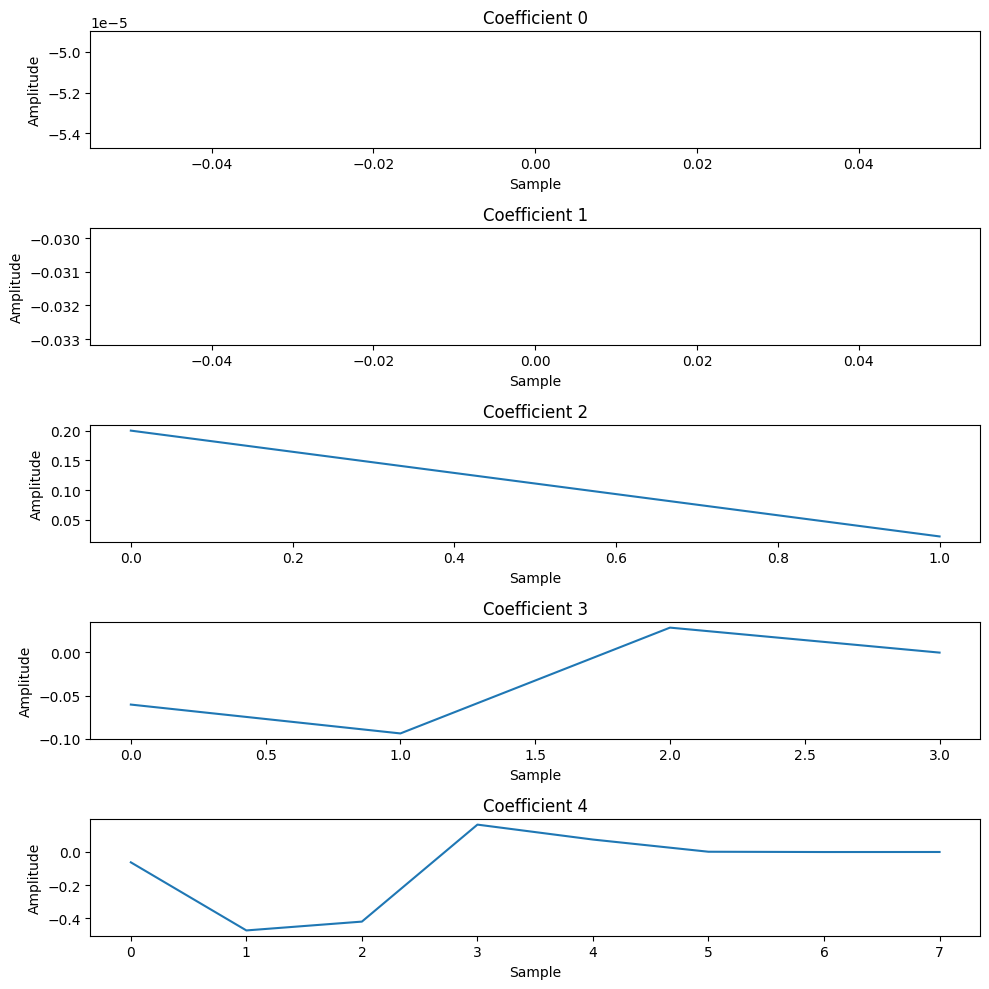

In [107]:
# print all the coefficients
fig, ax = plt.subplots(len(coeffs_1[0]), figsize=(10, 10))

# print the coefficients
print(coeffs_1[0])

for i, coeff in enumerate(coeffs_1[0]):
    ax[i].plot(coeff)
    ax[i].set_title(f'Coefficient {i}')
    ax[i].set_xlabel('Sample')
    ax[i].set_ylabel('Amplitude')

plt.tight_layout()
plt.show

In [124]:
from src.utils import upsampling_wavedec

t = [[1], [2], [1, 2], [1, 2, 3], [1, 2, 3, 4]]

upsampled = upsampling_wavedec(t)
print(upsampled)

for i in range(len(upsampled)):
    # multiply each level by 2 to the power of i to rescale
    level = max(0, i-1)
    upsampled[i] = upsampled[i] * (2 ** level)

print(upsampled)

[[1 1 1 1 1 1 1 1]
 [2 2 2 2 2 2 2 2]
 [1 1 1 1 2 2 2 2]
 [1 1 1 2 2 2 3 3]
 [1 1 2 2 3 3 4 4]]
[[ 1  1  1  1  1  1  1  1]
 [ 2  2  2  2  2  2  2  2]
 [ 2  2  2  2  4  4  4  4]
 [ 4  4  4  8  8  8 12 12]
 [ 8  8 16 16 24 24 32 32]]


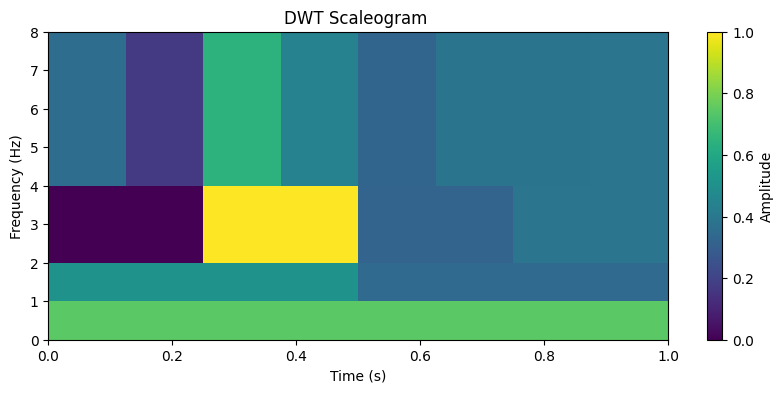

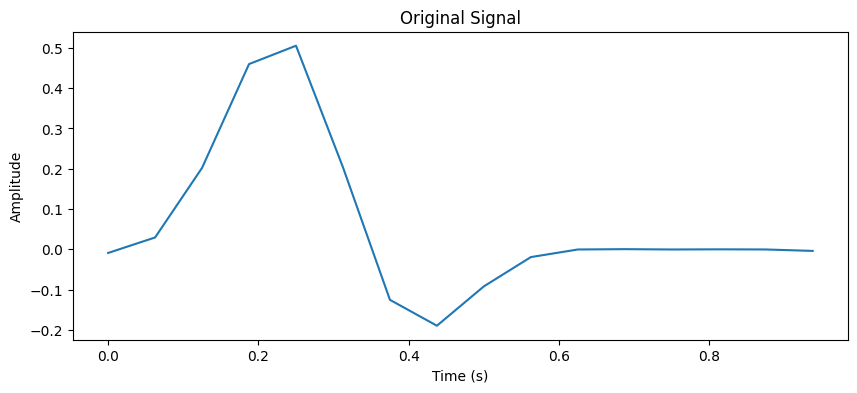

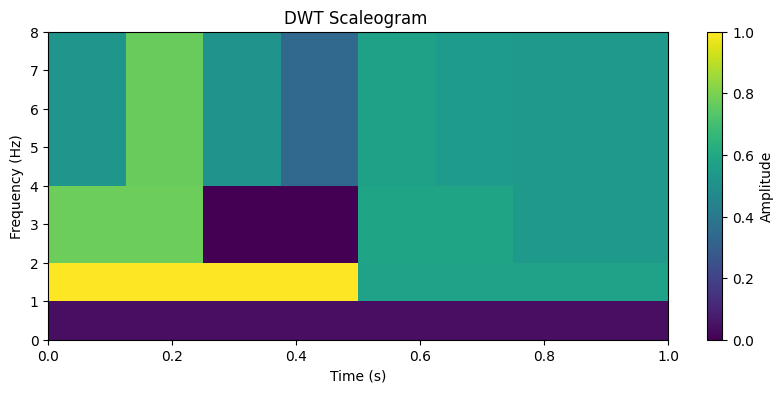

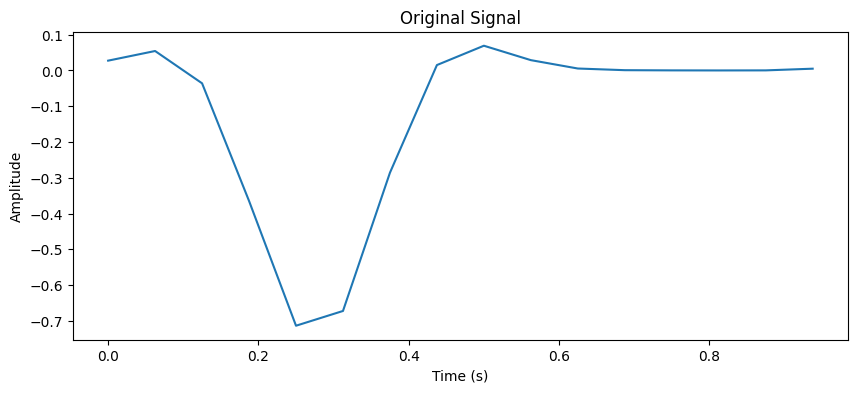

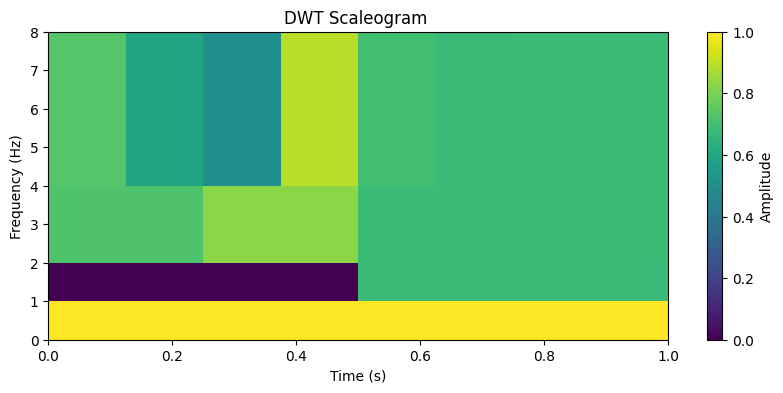

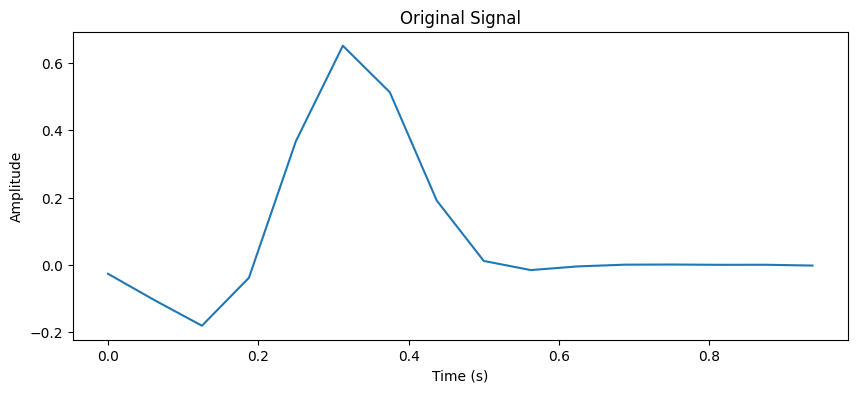

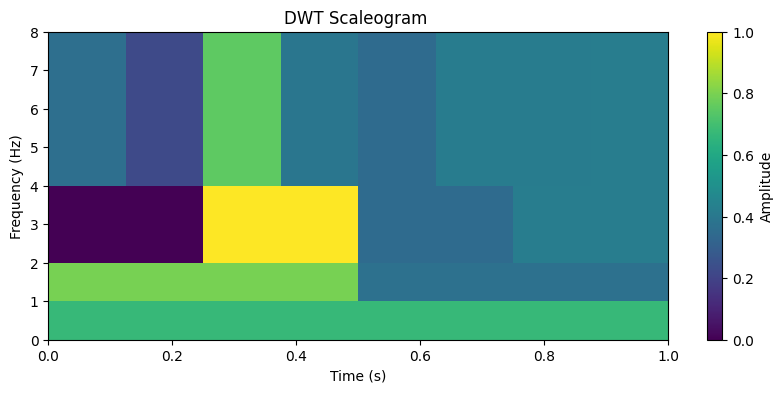

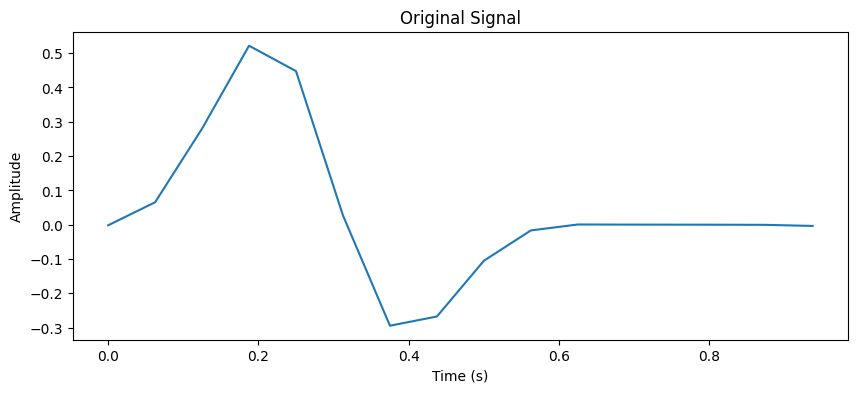

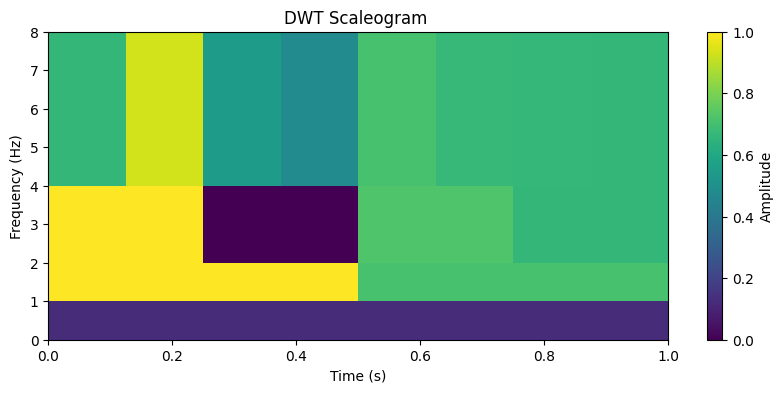

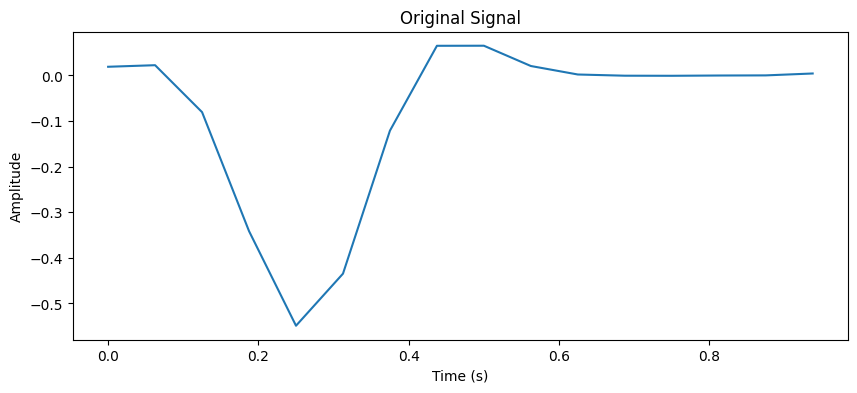

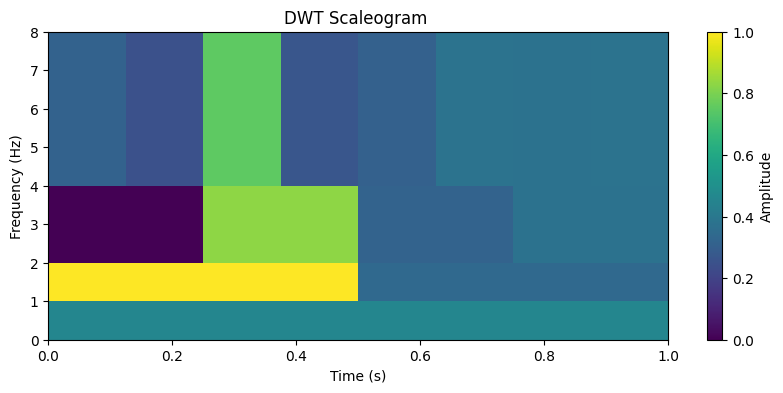

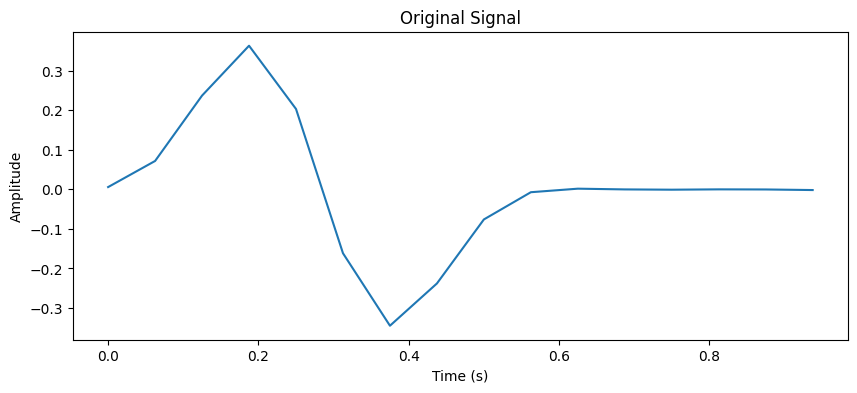

In [151]:
# create time vector
t = np.arange(0, len(signal_0)) / fs

for i, coeff_0 in enumerate(coeffs_0):
    plot_dwt_scaleogram_freq(fs, coeff_0, max_level, t, signals_0[i])
    # plot_dwt_scaleogram_freq(fs, coeff_0, max_level, t, signal_0, normalize=True)
    # plot_dwt_scaleogram_freq(fs, coeff_0, max_level, t, signal_0, rescale=True)
    # plot_dwt_scaleogram_freq(fs, coeff_0, max_level, t, signal_0, normalize=True, rescale=True)

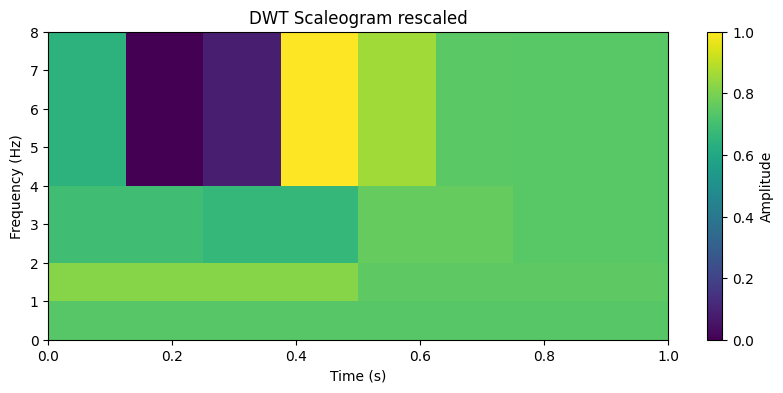

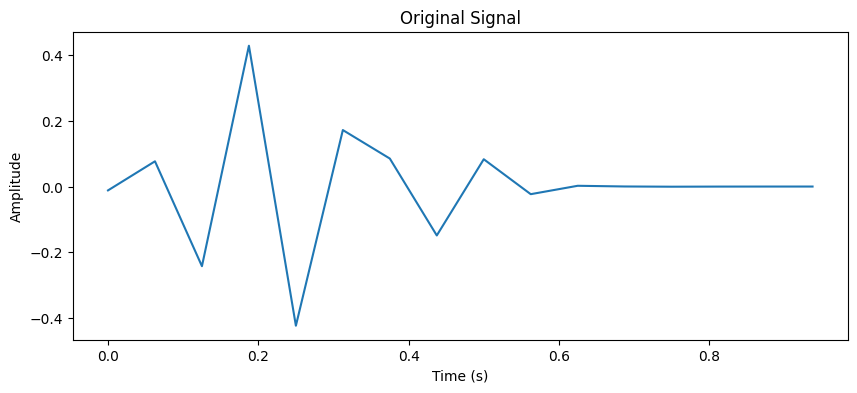

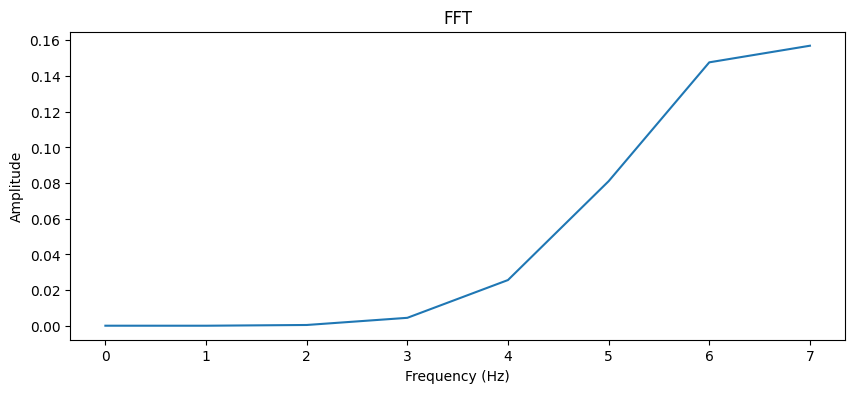

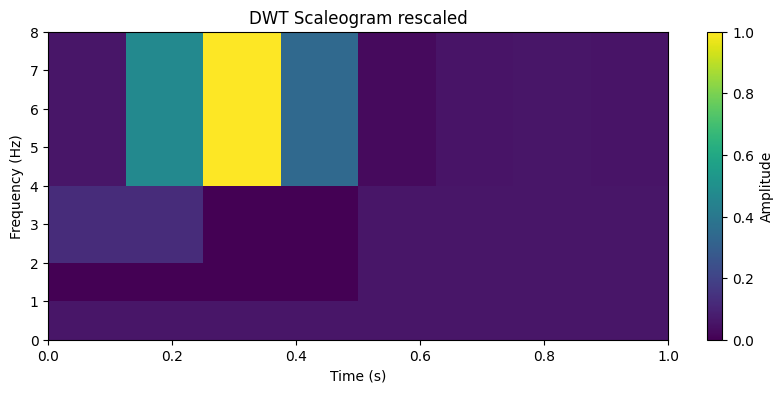

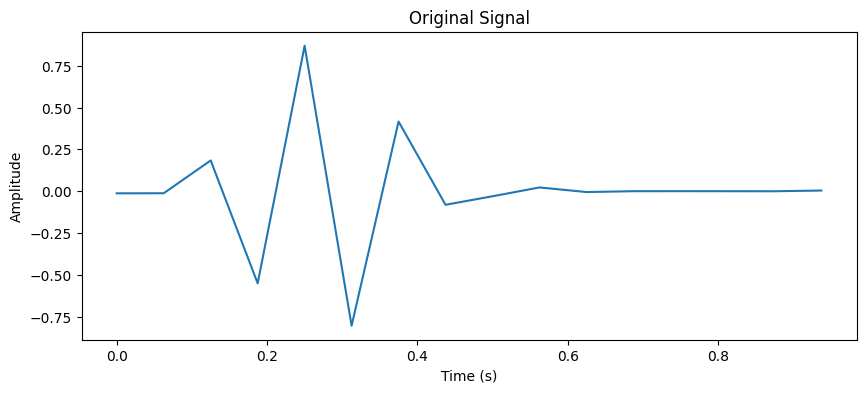

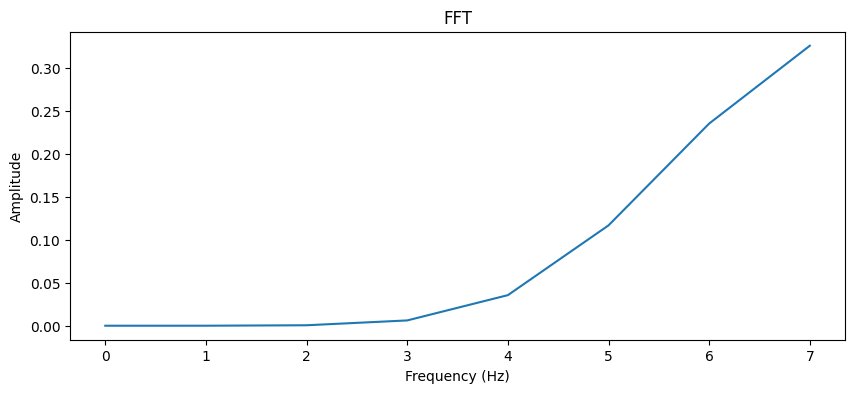

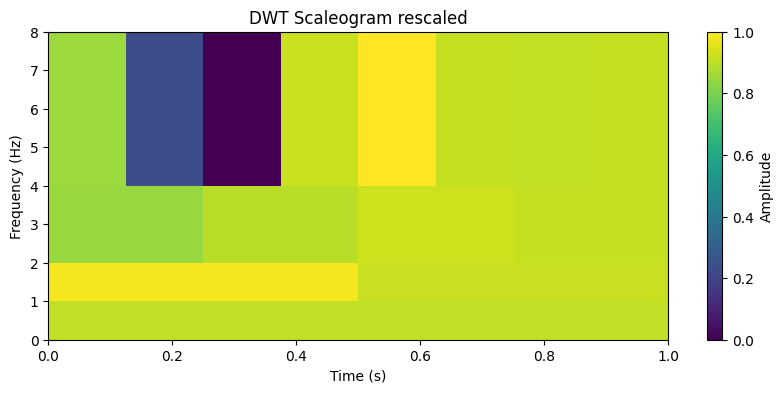

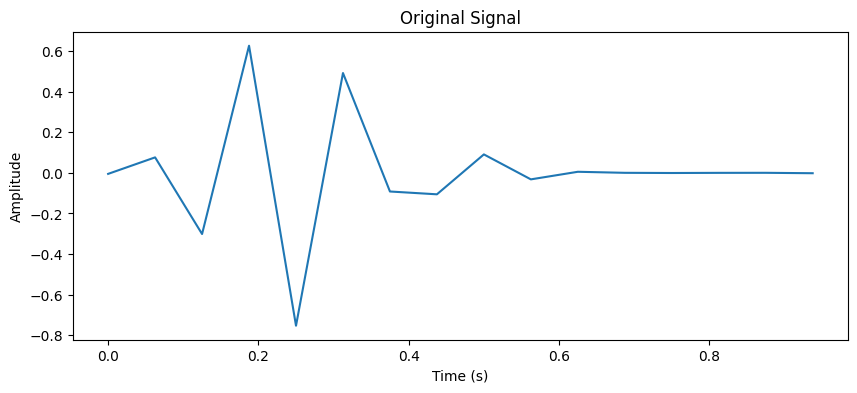

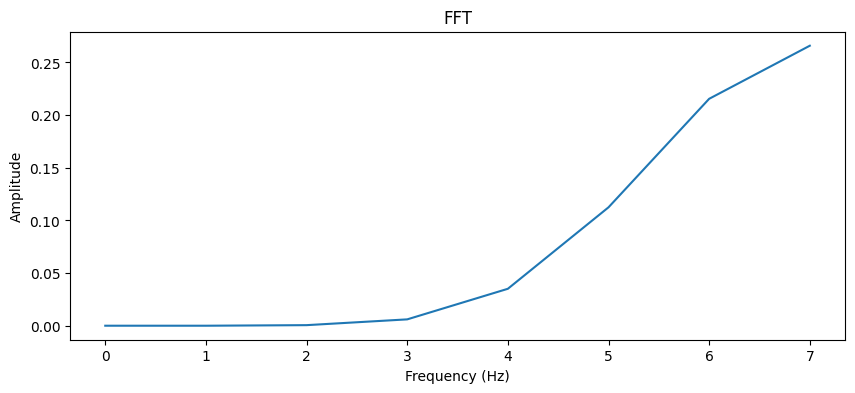

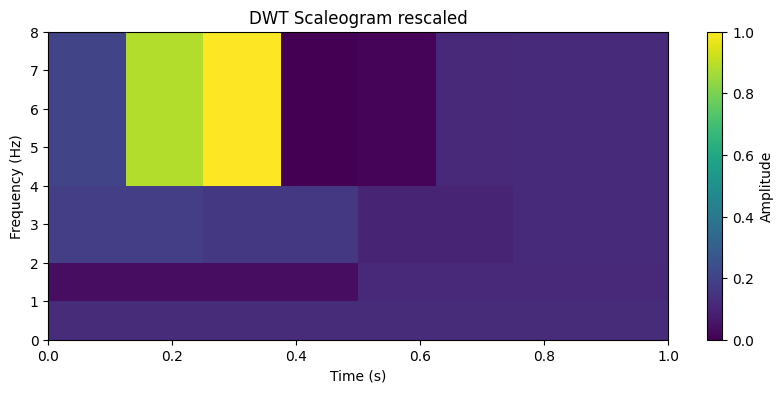

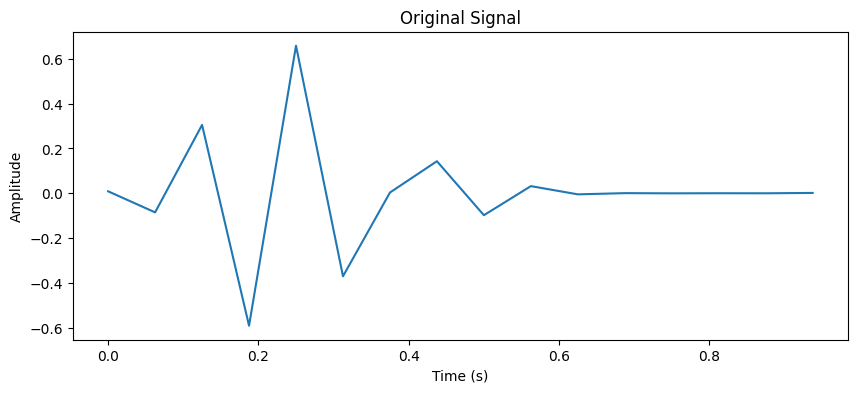

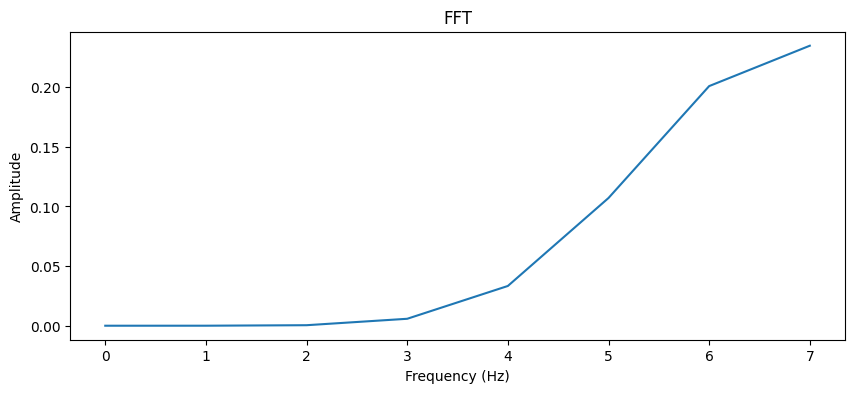

In [154]:
# create time vector
t = np.arange(0, len(signal_1)) / fs


for i, coeff_1 in enumerate(coeffs_1):
    plot_dwt_scaleogram_freq(fs, coeff_1, max_level, t, signals_1[i], rescale=True)
    plot_fft(signals_1[i], fs)

# plot_dwt_scaleogram_freq(fs, coefs_1, max_level, t, signal_1)
# plot_dwt_scaleogram_freq(fs, coefs_1, max_level, t, signal_1, normalize=True)
# plot_dwt_scaleogram_freq(fs, coefs_1, max_level, t, signal_1, rescale=True)
# plot_dwt_scaleogram_freq(fs, coefs_1, max_level, t, signal_1, normalize=True, rescale=True)

Wavelet: sym2
[8.0, 4.0, 2.0, 1.0, 0.5, 0.25, 0.125, 0.0625, 0.03125, 0.015625, 0]


/Users/alicia/Documents/Master/TFM/learnable-masks-explainability-time-series/.env/lib/python3.10/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 10 is too high: all coefficients will experience boundary effects.
  warnings.warn(


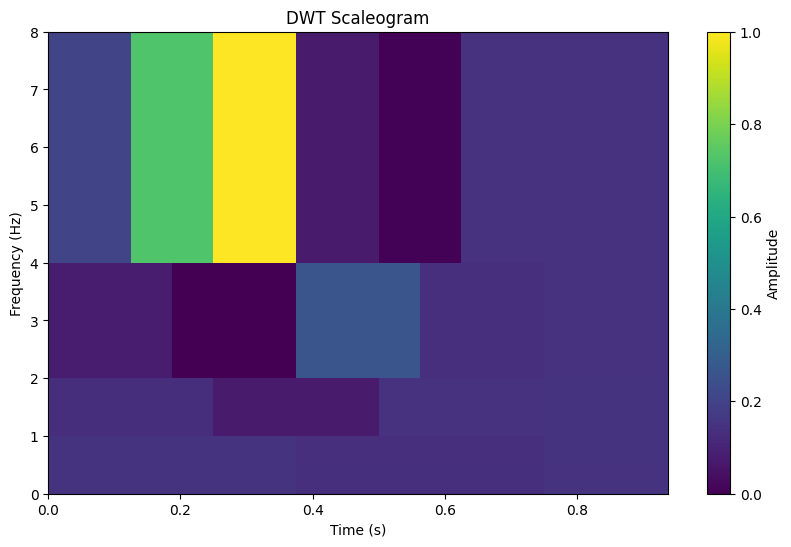

Wavelet: sym3
[8.0, 4.0, 2.0, 1.0, 0.5, 0.25, 0.125, 0.0625, 0.03125, 0.015625, 0]


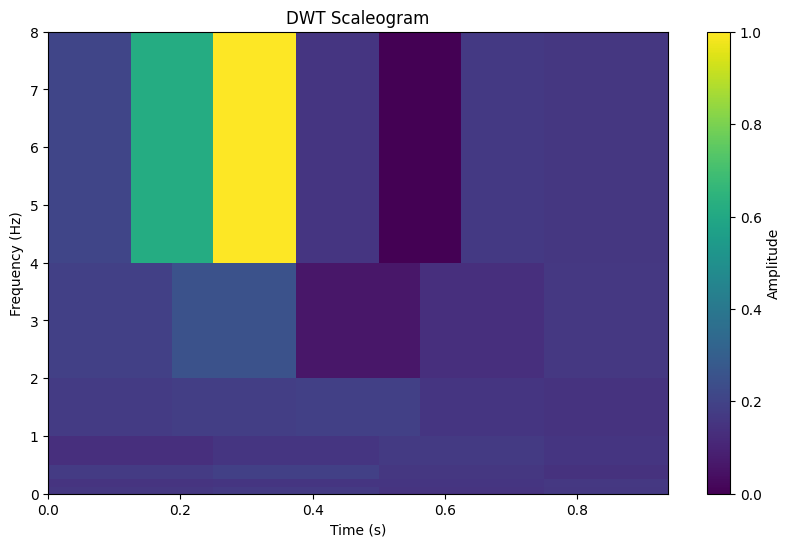

Wavelet: sym4
[8.0, 4.0, 2.0, 1.0, 0.5, 0.25, 0.125, 0.0625, 0.03125, 0.015625, 0]


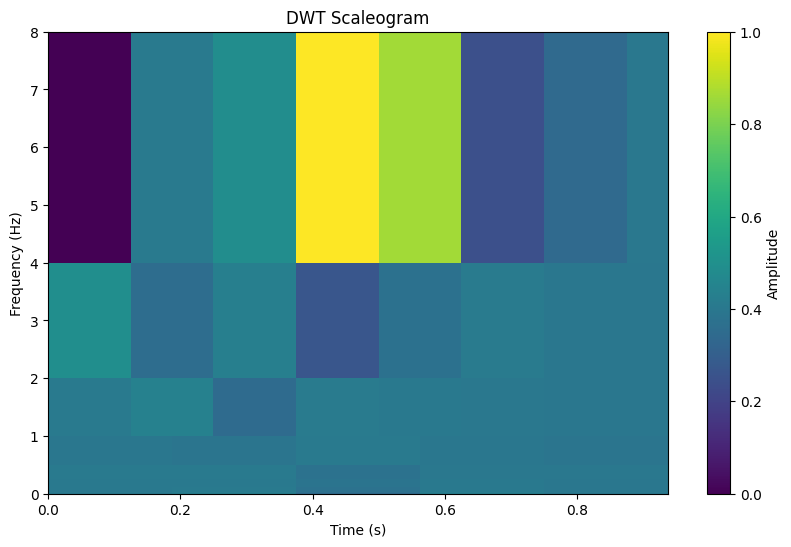

Wavelet: sym5
[8.0, 4.0, 2.0, 1.0, 0.5, 0.25, 0.125, 0.0625, 0.03125, 0.015625, 0]


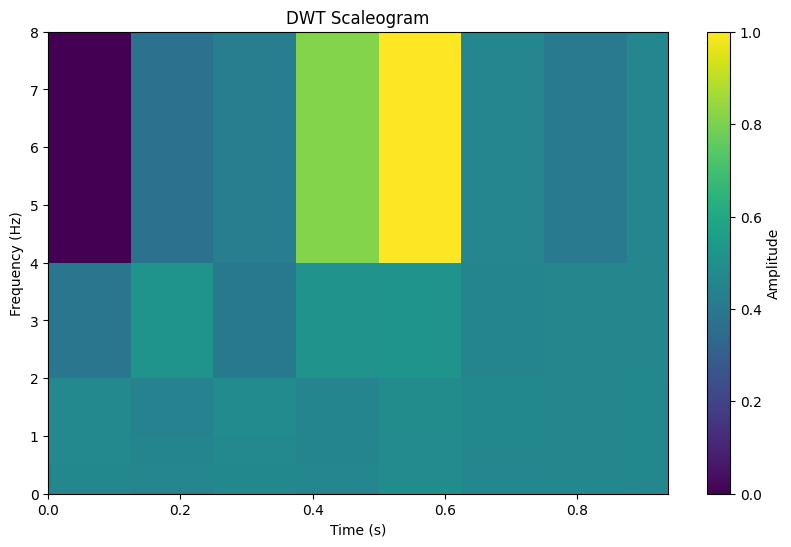

Wavelet: sym6
[8.0, 4.0, 2.0, 1.0, 0.5, 0.25, 0.125, 0.0625, 0.03125, 0.015625, 0]


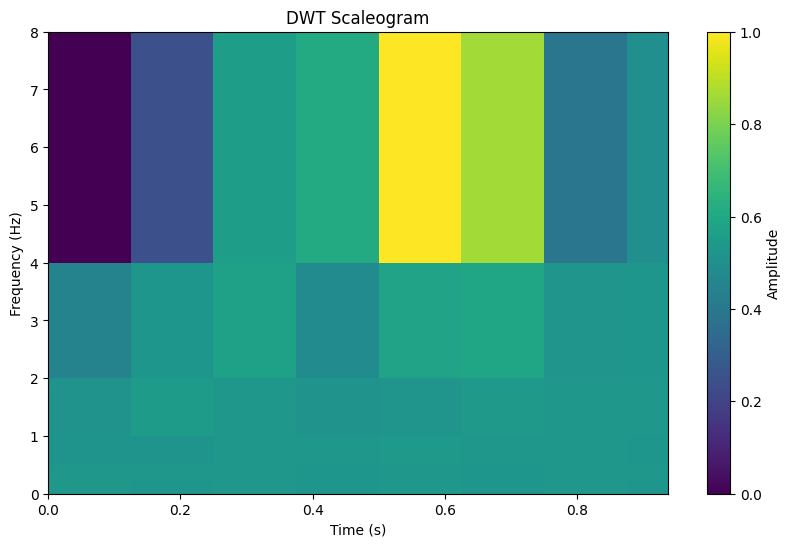

Wavelet: sym7
[8.0, 4.0, 2.0, 1.0, 0.5, 0.25, 0.125, 0.0625, 0.03125, 0.015625, 0]


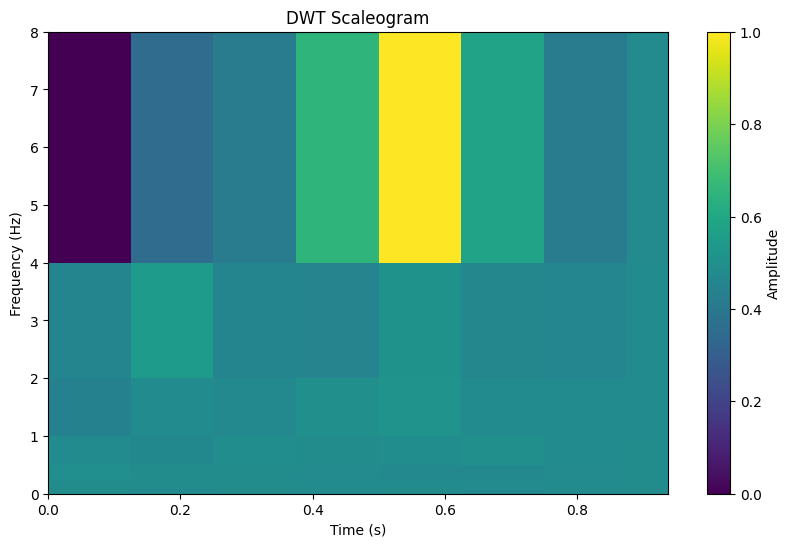

Wavelet: sym8
[8.0, 4.0, 2.0, 1.0, 0.5, 0.25, 0.125, 0.0625, 0.03125, 0.015625, 0]


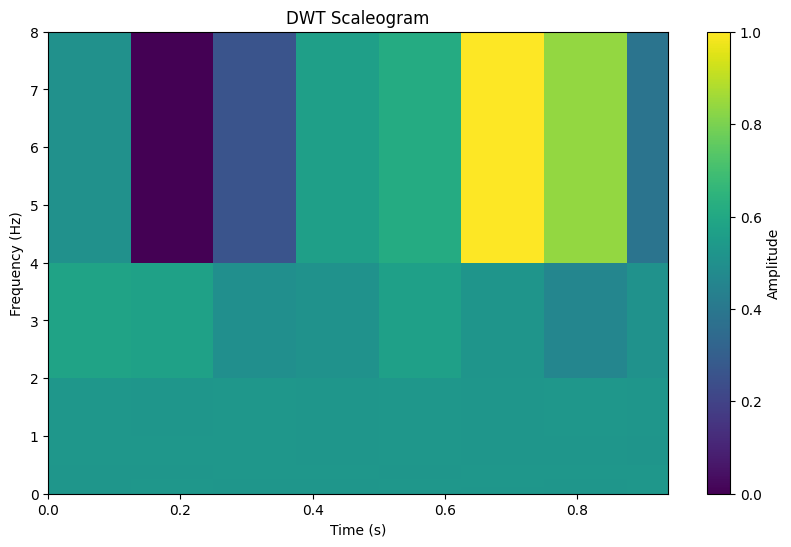

In [36]:
# wavelets = ['db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8']
# wavelets = ['coif1', 'coif2', 'coif3', 'coif4', 'coif5']
wavelets = ['sym2', 'sym3', 'sym4', 'sym5', 'sym6', 'sym7', 'sym8']

for wavelet in wavelets:
    print(f"Wavelet: {wavelet}")
    max_level = pywt.dwt_max_level(len(signal_1), wavelet)
    coefs = pywt.wavedec(signal_1, wavelet, level=10)
    plot_dwt_scaleogram_freq(fs, coefs, 10, t, signal_1)

/Users/alicia/Documents/Master/TFM/learnable-masks-explainability-time-series/.env/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:1430: UserWarning: nperseg = 64 is greater than input length  = 16, using nperseg = 16
  freqs, time, Zxx = _spectral_helper(x, x, fs, window, nperseg, noverlap,


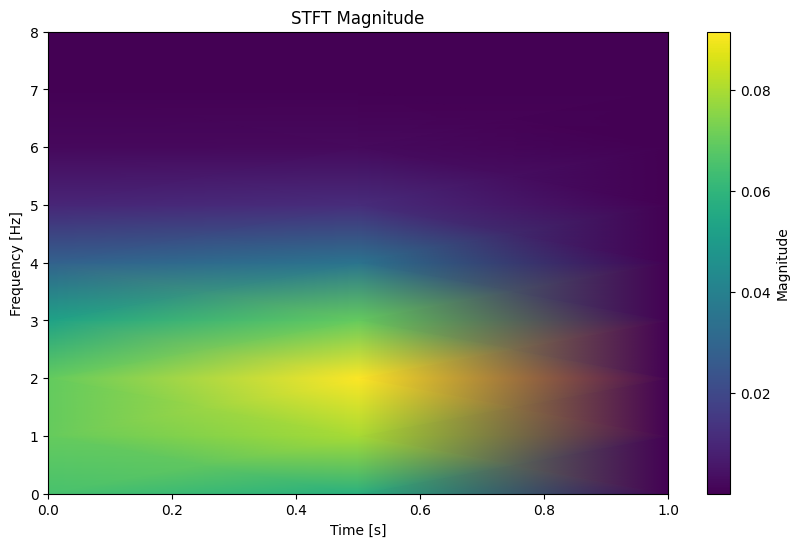

In [37]:
# do the stft
from scipy.signal import stft

# Compute the Short-Time Fourier Transform (STFT)
f, t_stft, Zxx = stft(signal_0, fs=fs, nperseg=64)

# Plot the STFT
plt.figure(figsize=(10, 6))
plt.pcolormesh(t_stft, f, np.abs(Zxx), shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='Magnitude')
plt.show()

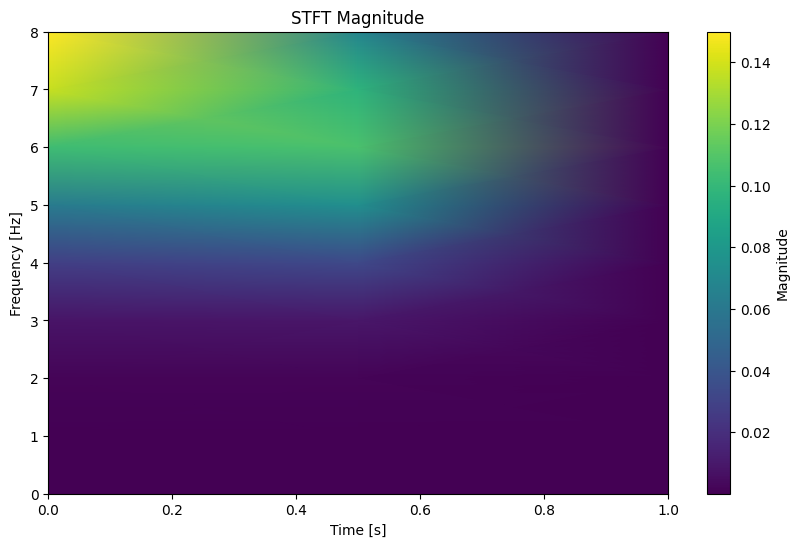

In [38]:
# Compute the Short-Time Fourier Transform (STFT)
f, t_stft, Zxx = stft(signal_1, fs=fs, nperseg=64)

# Plot the STFT
plt.figure(figsize=(10, 6))
plt.pcolormesh(t_stft, f, np.abs(Zxx), shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='Magnitude')
plt.show()

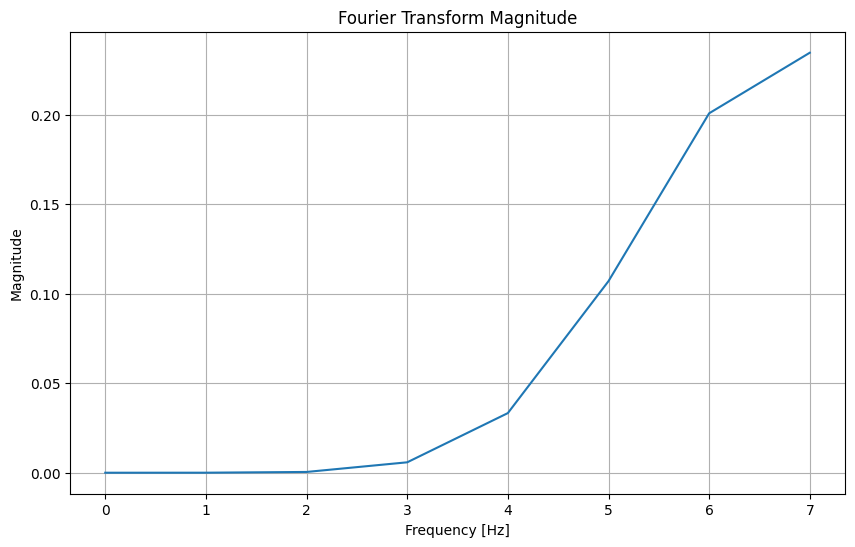

In [39]:
# do the fourier transform
from scipy.fft import fft, fftfreq

# Compute the Fourier Transform
N = len(signal_1)
T = 1.0 / fs
yf = fft(signal_1)
xf = fftfreq(N, T)[:N//2]

# Plot the Fourier Transform
plt.figure(figsize=(10, 6))
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.title('Fourier Transform Magnitude')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.grid()
plt.show()

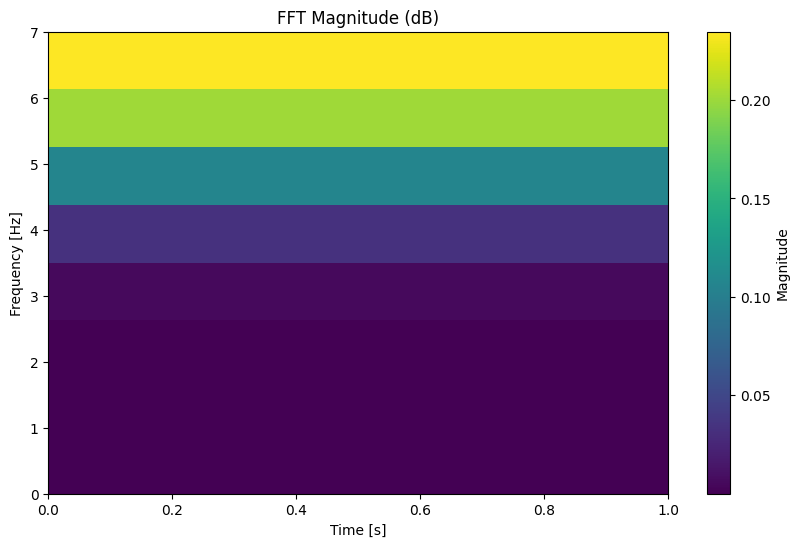

In [40]:
# Tile the FFT across time
mag = 2.0/N * np.abs(yf[:N//2])
scalogram = np.tile(mag[:, np.newaxis], (1, fs))

plt.figure(figsize=(10, 6))
plt.imshow(scalogram, aspect='auto', origin='lower',
           extent=[0, 1, xf[0], xf[-1]], cmap='viridis')
plt.title('FFT Magnitude (dB)')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='Magnitude')
plt.show()

# Testing flextime with the simulated data

In [52]:
import os
import torch
import pickle
import numpy as np
from types import SimpleNamespace
from torch.utils.data import DataLoader, TensorDataset


from src.models.simple import SimpleCNN
from src.attribution import compute_attribution
from src.evaluation.evaluation import evaluate_attributions

In [43]:
set_seed(42)

# to mps if available otherwise to cpu
device = torch.device('mps' if torch.backends.mps.is_available()  else 'cpu')
print(f"Using device: {device}")

# load the model
model = SimpleCNN(in_channels=1, out_channels=2, hidden_size=64, kernel_size=5)

# load the model weights
model.load_state_dict(torch.load("./model/checkpoint/simpleCNN_5.pth", map_location=torch.device('mps')))
model.to(device)

Using device: mps


SimpleCNN(
  (cnn): Sequential(
    (0): Conv1d(1, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 2, kernel_size=(5,), stride=(1,))
    (4): AdaptiveAvgPool1d(output_size=1)
    (5): Flatten(start_dim=1, end_dim=-1)
  )
)

In [44]:
set_seed(42)

# Load and shape synthetic test data
x = None
y = None

# load the data from synthetic data
data_folder = "./data/synthetic/test_3"
data_files = os.listdir(data_folder)
for file in data_files:
    if "samples_0" in file:
        if x is None and y is None:
            x = np.load(os.path.join(data_folder, file))
            y = np.zeros(5000)
        else:
            x = np.concatenate([x, np.load(os.path.join(data_folder, file))])
            y = np.concatenate([y, np.zeros(5000)])
    elif "samples_1" in file:
        if x is None and y is None:
            x = np.load(os.path.join(data_folder, file))
            y = np.ones(5000)
        else:
            x = np.concatenate([x, np.load(os.path.join(data_folder, file))])
            y = np.concatenate([y, np.ones(5000)])
    else:
        print("File not recognized")
        continue
    

x = x[:, np.newaxis, :]

print(x.shape)
print(y.shape)

# convert the data to torch tensors
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

# Shuffle indices once
indices = torch.randperm(len(x))

# Apply the shuffle
x_shuffled = x[indices]
y_shuffled = y[indices]

# create the dataset
dataset = TensorDataset(x_shuffled, y_shuffled)

# create the DataLoader
test_loader = DataLoader(dataset, batch_size=128)


(10000, 1, 16)
(10000,)


In [45]:
print(f"Number of batches: {len(test_loader)}")
for batch in test_loader:
    print(f"Batch shape {len(batch)}, sample and label")
    x, y = batch
    print(f"Sample batch size {len(x)}")
    print(f"Label batch size {len(y)}, {y}")
    print(f"Sample shape {x.shape}")
    print(f"Label shape {y.shape}")
    break

Number of batches: 79
Batch shape 2, sample and label
Sample batch size 128
Label batch size 128, tensor([1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
        0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1,
        0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
        0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,
        0, 1, 1, 1, 0, 1, 1, 1])
Sample shape torch.Size([128, 1, 16])
Label shape torch.Size([128])


In [47]:
attributions = {}
attributions['deletion'] = {}
attributions['insertion'] = {}
predictions = []
labels = []

# prediction
for batch in test_loader:
    # get data
    x, y = batch
    x = x.to(device)
    output = model(x)

    predictions.append(output)
    labels.append(y)

# concatenat the predictions and the labels through the first dim
predictions = torch.cat(predictions, dim=0)
labels = torch.cat(labels, dim=0)

In [48]:
print(predictions.shape)
print(predictions[0])
print(labels.shape)

torch.Size([10000, 2])
tensor([-4.3709,  4.3625], device='mps:0', grad_fn=<SelectBackward0>)
torch.Size([10000])


In [49]:
correct = 0
for i in range(len(predictions)):
    if predictions[i].argmax() == labels[i]:
        correct += 1

print(f"Accuracy: {correct / len(predictions)}")

Accuracy: 1.0


In [50]:
# save it in the attributions dict
attributions['predictions'] = predictions
attributions['labels'] = labels

In [51]:
# evaluate flextime
fs = 16
batch_size = 128
n_filters = 64
numtaps = 9
key_ = f'flexime_{n_filters}_{numtaps}_{batch_size}'
print(key_)

flexime_64_9_128


In [53]:
set_seed(42)
method = 'flextime'

args = SimpleNamespace(n_taps=numtaps, n_filters=n_filters, sample_freq=fs, time_len=fs)
print(args.n_taps)
print(args.n_filters)
print(args.sample_freq)
print(args.time_len)

attrs, masks = compute_attribution(method = method, model = model, test_loader= test_loader, args = args, device=device, verbose=False)

9
64
16
16
Batch 0 of 79
Sample 0 of 128
Sample 1 of 128
Sample 2 of 128
Sample 3 of 128
Sample 4 of 128
Sample 5 of 128
Sample 6 of 128
Sample 7 of 128
Sample 8 of 128
Sample 9 of 128
Sample 10 of 128
Sample 11 of 128
Sample 12 of 128
Sample 13 of 128
Sample 14 of 128
Sample 15 of 128
Sample 16 of 128
Sample 17 of 128
Sample 18 of 128
Sample 19 of 128
Sample 20 of 128
Sample 21 of 128
Sample 22 of 128
Sample 23 of 128
Sample 24 of 128
Sample 25 of 128
Sample 26 of 128
Sample 27 of 128
Sample 28 of 128
Sample 29 of 128
Sample 30 of 128
Sample 31 of 128
Sample 32 of 128
Sample 33 of 128
Sample 34 of 128
Sample 35 of 128
Sample 36 of 128
Sample 37 of 128
Sample 38 of 128
Sample 39 of 128
Sample 40 of 128
Sample 41 of 128
Sample 42 of 128
Sample 43 of 128
Sample 44 of 128
Sample 45 of 128
Sample 46 of 128
Sample 47 of 128
Sample 48 of 128
Sample 49 of 128
Sample 50 of 128
Sample 51 of 128
Sample 52 of 128
Sample 53 of 128
Sample 54 of 128
Sample 55 of 128
Sample 56 of 128
Sample 57 of 128

In [54]:
attributions[key_] = attrs
attributions[f'filtermasks_{key_}'] = masks

In [ ]:
# # read data
# folder = 'public/simple/'
# path = f'{folder}{key_}_results_1.pkl'

# with open(path, 'rb') as f:
#     attributions = pickle.load(f)
# print(f"Attributions loaded from {path}")

Attributions loaded from public/simple/flexime_128_501_128_results_1.pkl


In [55]:
print(attributions.keys())
print(key_)
print(len(attributions[key_]))
print(len(attrs[0]))
print(len(masks))
print(len(test_loader))

dict_keys(['deletion', 'insertion', 'predictions', 'labels', 'flexime_64_9_128', 'filtermasks_flexime_64_9_128'])
flexime_64_9_128
79
128
79
79


In [56]:
print(type(attributions[key_]))
print(len(attributions[key_]))
print(len(attributions[key_][0]))
print(len(attributions[key_][0][0]))
print(len(attributions[key_][0][0][0]))

<class 'list'>
79
128
9
1


In [57]:
key_2 = f'filtermasks_{key_}'
print(type(attributions[key_2]))
print(len(attributions[key_2]))
print(len(attributions[key_2][0]))
print(len(attributions[key_2][0][0]))

<class 'list'>
79
128
64


In [ ]:
set_seed(42)

# compute accuracy scores
quantiles = np.arange(0, 1.05, 0.05)
for mode in ['deletion', 'insertion']:
    if not mode in attributions.keys():
        attributions[mode] = {}
    
    acc_scores = evaluate_attributions(model, test_loader, attributions[key_], quantiles=quantiles, mode=mode, device=device)
    attributions[mode][key_] = acc_scores

In [59]:
print(attributions.keys())
print(len(quantiles))

dict_keys(['deletion', 'insertion', 'predictions', 'labels', 'flexime_64_9_128', 'filtermasks_flexime_64_9_128'])
21


In [60]:
set_seed(42)

# stores the accuracy, mean true class prob and cross-entropy loss throughout the quantiles
for k in attributions['insertion'].keys():
    print(k)
    print(len(attributions['insertion'][k]))
    print(len(attributions['insertion'][k][0]))
    for val in range(len(attributions['insertion'][k])):
        print(attributions['insertion'][k][val])

flexime_64_9_128
3
21
[0.5, 0.5, 0.5, 0.9548, 0.9548, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.500000010728836, 0.500000010728836, 0.500000010728836, 0.9540175168991089, 0.9540175168991089, 0.9999325456619262, 0.9999325456619262, 0.9999874858856201, 0.9999874858856201, 0.9999776220321656, 0.9999776220321656, 0.9999776220321656, 0.9999719103813172, 0.9999719103813172, 0.9999721502304078, 0.9999721502304078, 0.9999722984313965, 0.9999722984313965, 0.9999722999572754, 0.9999722999572754, 0.9999722976684571]
[53.30962425470352, 53.30962425470352, 53.30962425470352, 3.2782516293227673, 3.2782516293227673, 0.0026496080918150255, 0.0026496080918150255, 0.0004906942502884704, 0.0004906942502884704, 0.0008775215719651897, 0.0008775215719651897, 0.0008775215719651897, 0.001102406268728373, 0.001102406268728373, 0.0010931318543043744, 0.0010931318543043744, 0.0010872361335714231, 0.0010872361335714231, 0.0010872445163840894, 0.0010872445163840894, 0.00108

In [61]:
from quantus.metrics import Complexity

complexities = {}
grad_complexties = {}
sensitivity = {}
rel_out_sens = {}
comp = Complexity()

In [62]:
for att in attributions:
    print(att)

deletion
insertion
predictions
labels
flexime_64_9_128
filtermasks_flexime_64_9_128


In [63]:
set_seed(42)

for att in attributions:
    if att == 'insertion':
        print(attributions['insertion'].keys())
    
for key in attributions['insertion'].keys():
    if not key in complexities.keys():
        print('first')
        complexities[key] = []
        grad_complexties[key] = []

    scores = []
    grad_scores = []

    for i in range(len(attributions[key])):
        expl = np.reshape(attributions[key][i], (attributions[key][i].shape[0], -1))
        expl = expl.to(dtype=torch.float32).numpy()
        
        ex = np.maximum(attributions[key][i].numpy(), 0)
        if 'filterbank' in key:
            ex = np.transpose(ex, (0, 2, 1))

        # min max normalize
        ex_min = np.min(ex, axis = -1, keepdims=True)
        ex_max = np.max(ex, axis = -1, keepdims=True)
        ex = (ex - ex_min) / (ex_max - ex_min + 1e-10)
        # ex = (ex - np.min(ex, axis = -1, keepdims=True)) / (np.max(ex, axis = -1, keepdims=True) - np.min(ex, axis = -1, keepdims=True) + 1e-10)
        expl_grad = np.abs(np.diff(ex, axis = -1)).sum(axis=-1)
        expl_grad = np.reshape(expl_grad, (attributions[key][i].shape[0], -1))

        expl = np.maximum(expl, 0)
        # check if all expl values are zero
        if np.all(expl == 0):
            print("All zeros")
            # add a small epsilon to avoid division by zero
            expl = np.ones_like(expl) * 1e-10

        # to compute complexities it has to be a numpy float32 otherwise err
        complexity = comp.evaluate_batch(expl, expl)
        complexity = np.nan_to_num(complexity)
        expl_grad = np.nan_to_num(expl_grad)
        scores += complexity.tolist()
        grad_scores += list(expl_grad)

    complexities[key].append(np.mean(scores))
    grad_complexties[key].append(np.mean(grad_scores))

print(complexities)
print(grad_complexties)

dict_keys(['flexime_64_9_128'])
first
{'flexime_64_9_128': [np.float64(1.772349576141555)]}
{'flexime_64_9_128': [np.float64(0.0)]}


In [72]:
# dump to file
folder = 'public/simple/'
path = f'{folder}{key_}_results_3.pkl'

with open(path, 'wb') as f:
    pickle.dump(attributions, f)
print(f"Saved to {path}")

Saved to public/simple/flexime_64_9_128_results_3.pkl


In [75]:
def compute_entropy_sample(attribution, epsilon=1e-10):
    abs_attr = np.abs(attribution)
    sum_attr = np.sum(abs_attr) + epsilon
    prob_dist = abs_attr / sum_attr
    entropy = -np.sum(prob_dist * np.log(prob_dist + epsilon))
    return entropy

In [77]:
# Compute the entropy-based complexity
complexity_scores = []

for i in range(len(attributions[key_])):
    attr = np.reshape(attributions[key][i], (attributions[key][i].shape[0], -1))
    scores = []
    for sample in attr:
        sample = sample.detach().cpu().numpy()
        c = compute_entropy_sample(sample)
        c = np.nan_to_num(c)
        scores.append(c)
    complexity_scores += scores

# compute the mean
mean_complexity = np.mean(complexity_scores)
print("Complexity Scores:")
print(mean_complexity)

Complexity Scores:
1.7723495751608453


In [64]:
from scipy.fftpack import fft, fftfreq
import matplotlib.pyplot as plt

def plot_freq_heatmap(signal, attribution, fs=1000):
    # Compute FFT
    N = len(signal)
    freq = fftfreq(N, d=1/fs)  # Frequency bins
    magnitude = np.abs(fft(signal))  # Magnitude of FFT

    # Keep only positive frequencies
    pos_mask = freq >= 0
    freq = freq[pos_mask]
    magnitude = magnitude[pos_mask]

    # Normalize attribution scores to [0,1]
    attr_resized = np.interp(freq, np.linspace(freq.min(), freq.max(), len(attribution)), attribution)
    attr_norm = (attr_resized - np.min(attr_resized)) / (np.max(attr_resized) - np.min(attr_resized) + 1e-10)

    # Create a 2D grid for heatmap
    freq_grid, mag_grid = np.meshgrid(freq, magnitude)
    attr_grid = np.tile(attr_norm[:-1], (len(magnitude) - 1, 1))  # Repeat attribution scores along the magnitude axis

    # Plot heatmap
    plt.figure(figsize=(10, 5))
    plt.plot(freq, magnitude, label="FFT Magnitude", color='black', alpha=0.6)
    plt.pcolormesh(freq_grid, mag_grid, attr_grid, shading='auto', cmap='Greens')
    plt.colorbar(label="Normalized Attribution Score")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Magnitude")
    plt.title("Attribution Heatmap in Frequency Domain")
    plt.show()

(array([0, 1]), array([5000, 5000]))
79
(128, 64)


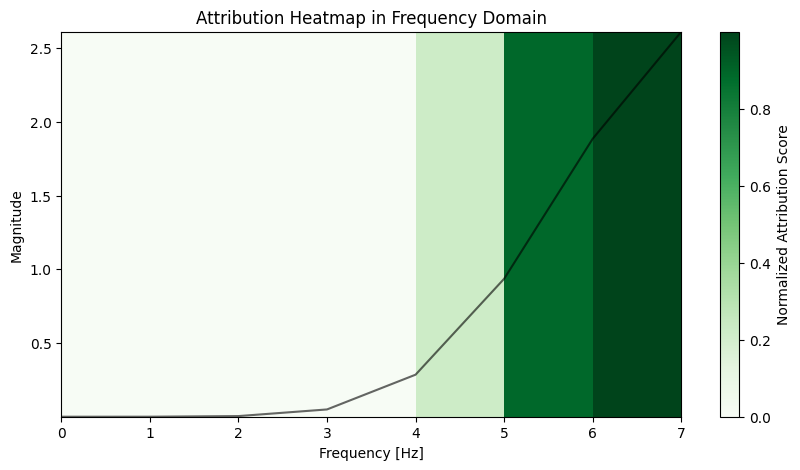

Prediction: 1, Label: 1


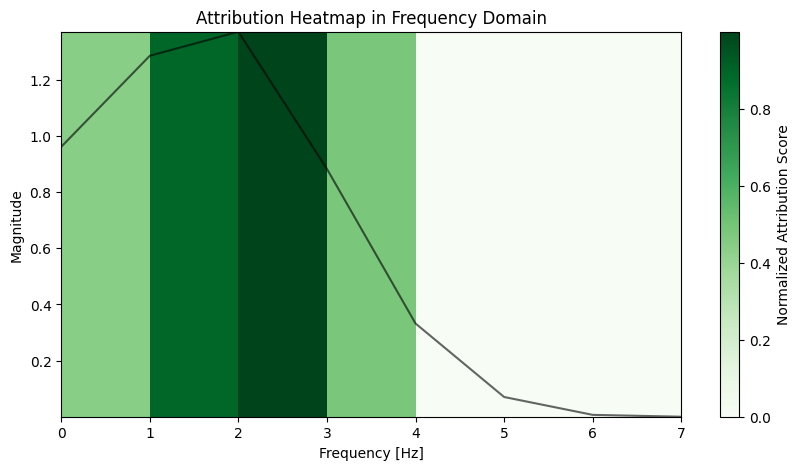

Prediction: 0, Label: 0


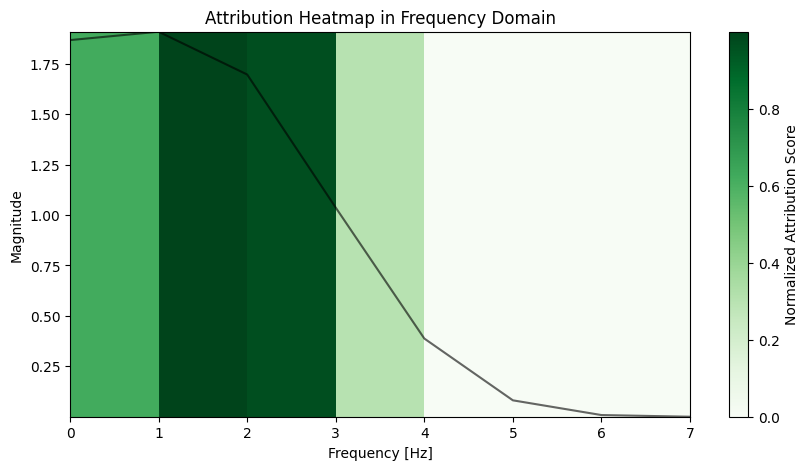

Prediction: 0, Label: 0


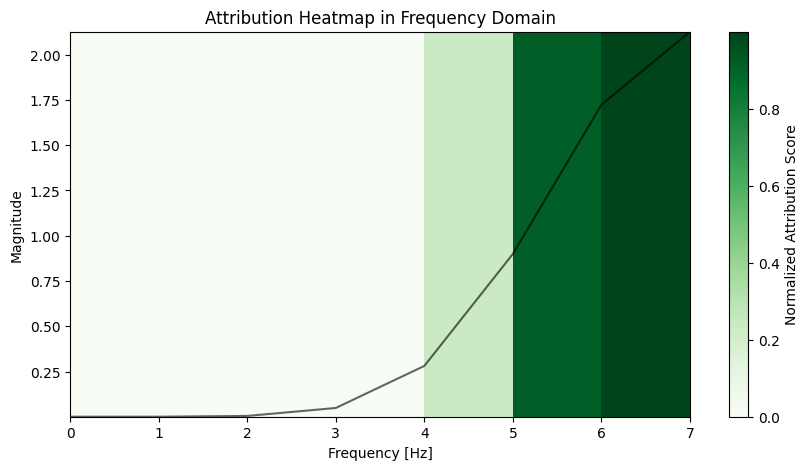

Prediction: 1, Label: 1


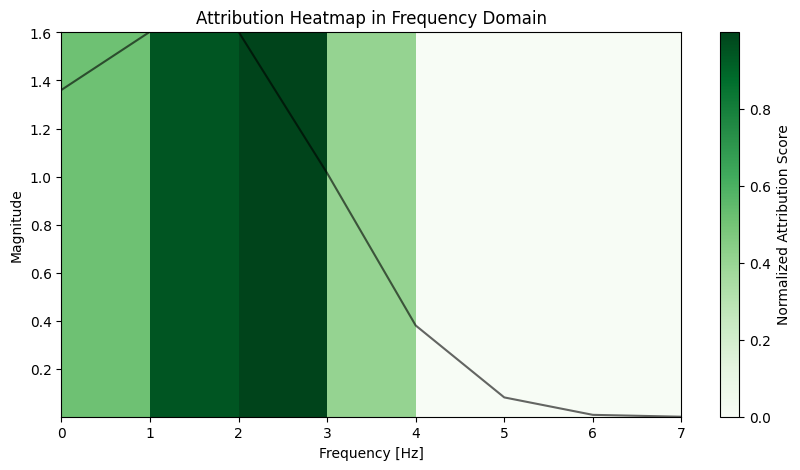

Prediction: 0, Label: 0


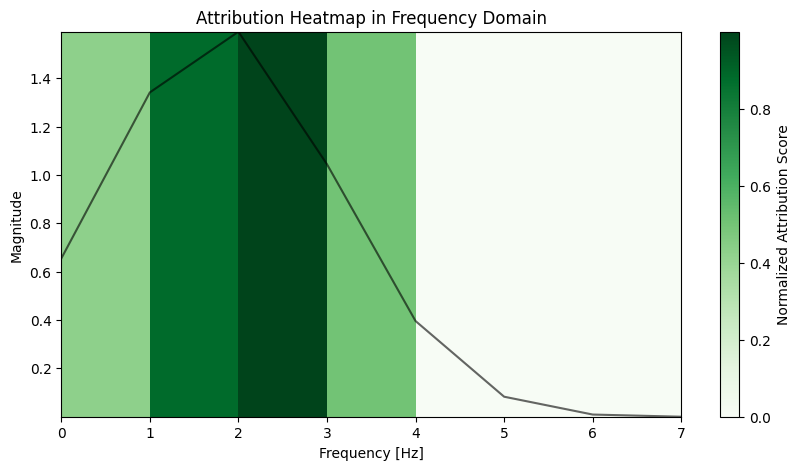

Prediction: 0, Label: 0


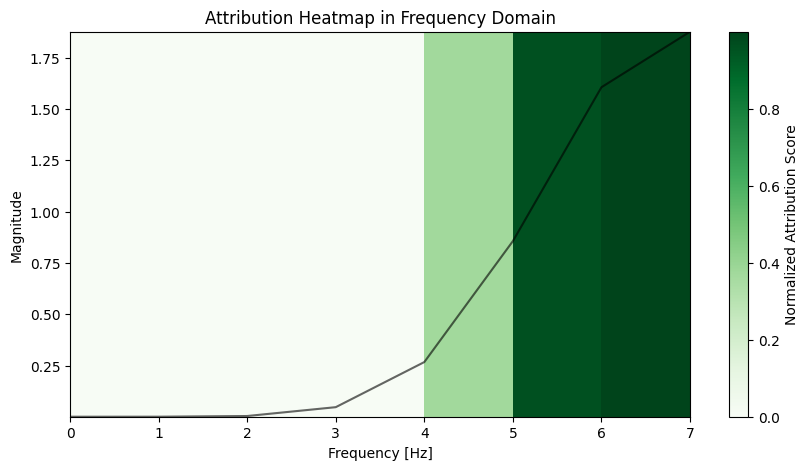

Prediction: 1, Label: 1


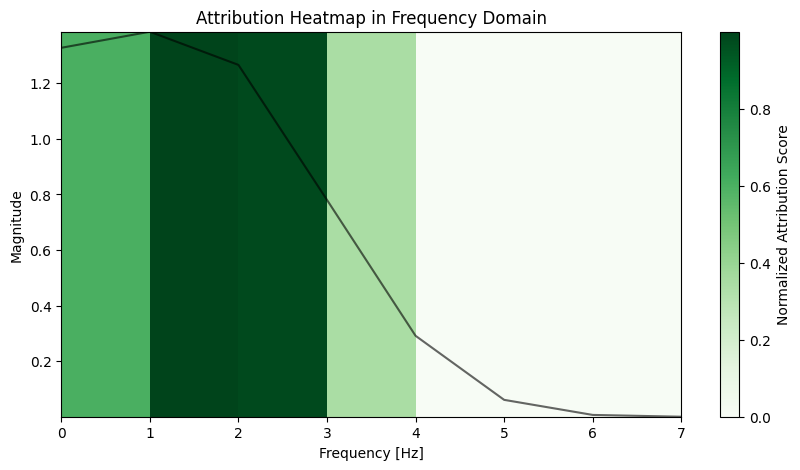

Prediction: 0, Label: 0


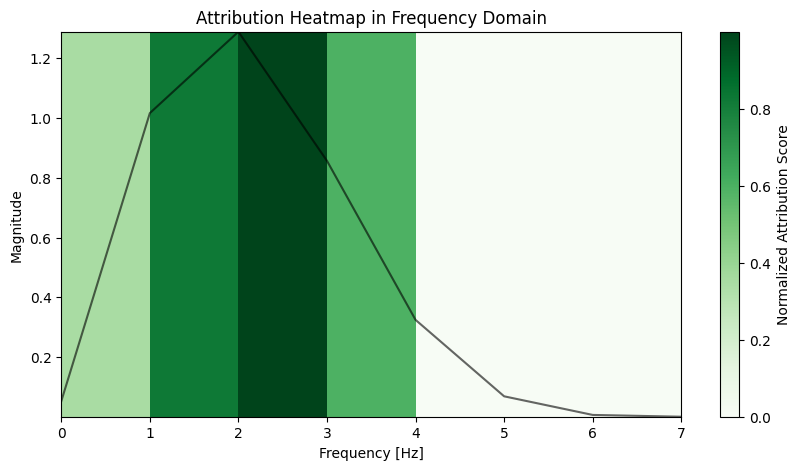

Prediction: 0, Label: 0


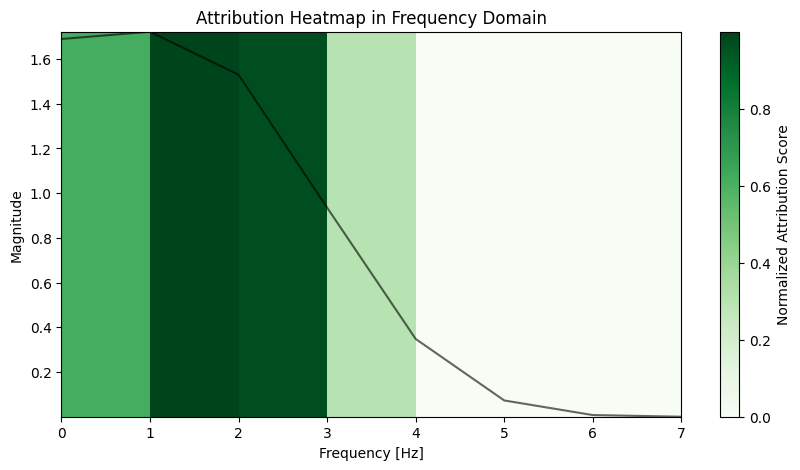

Prediction: 0, Label: 0


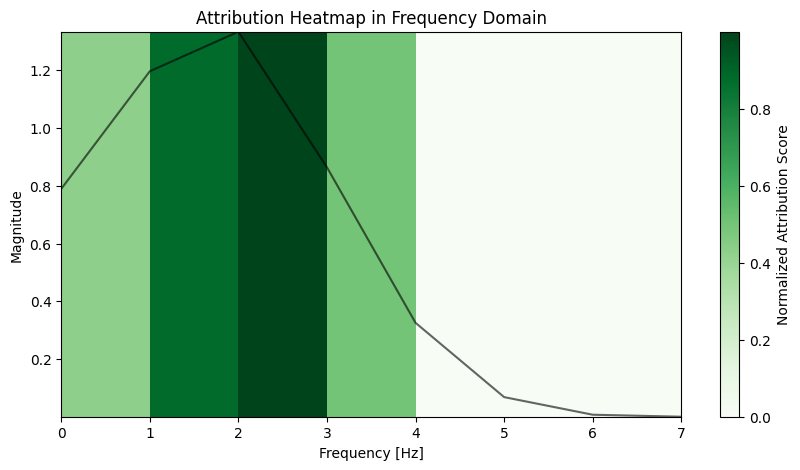

Prediction: 0, Label: 0


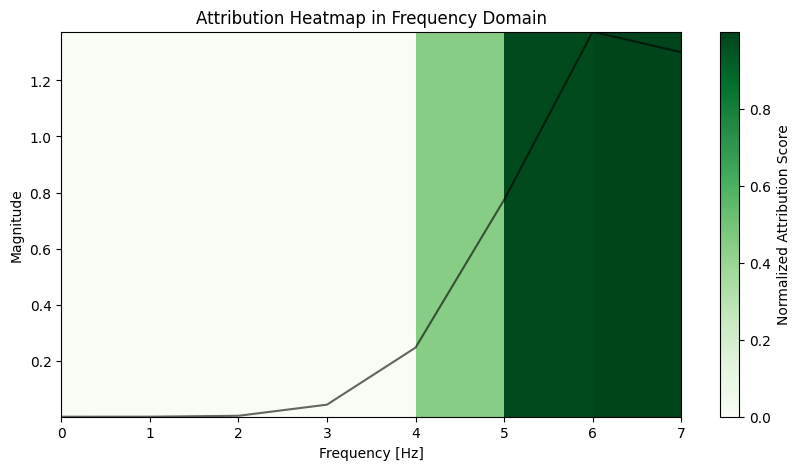

Prediction: 1, Label: 1


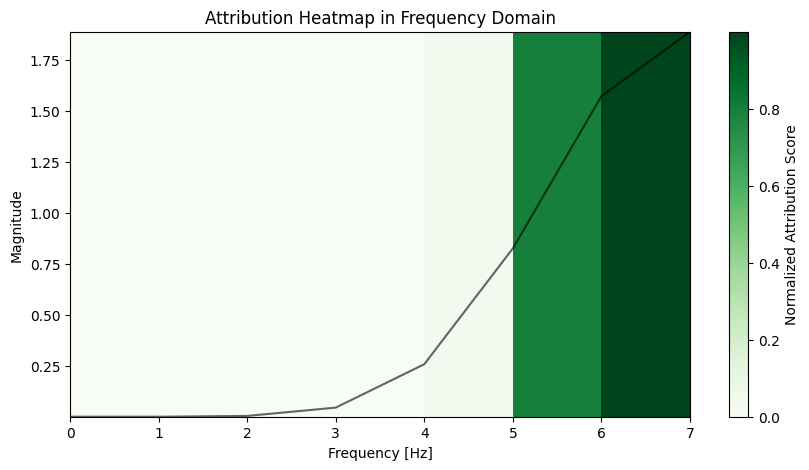

Prediction: 1, Label: 1


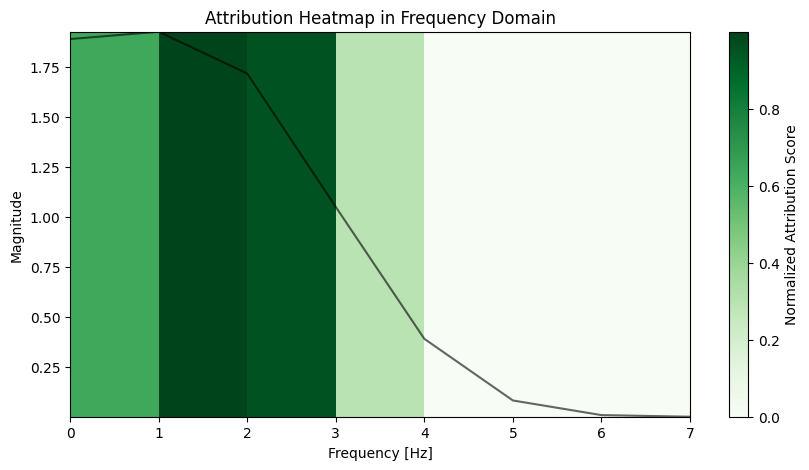

Prediction: 0, Label: 0


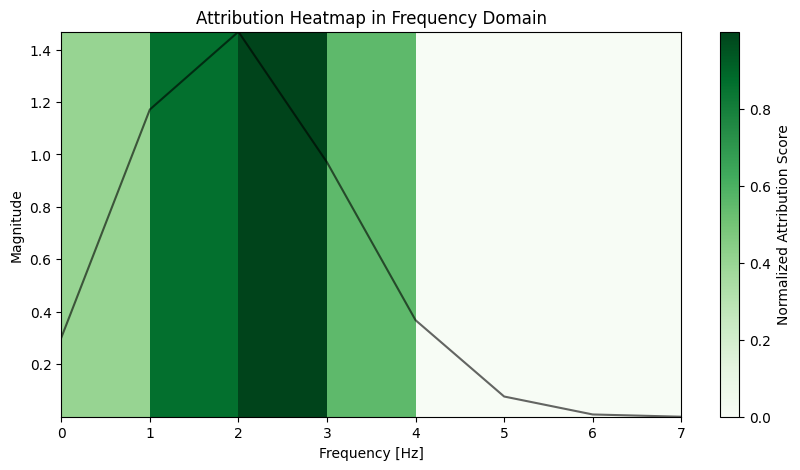

Prediction: 0, Label: 0


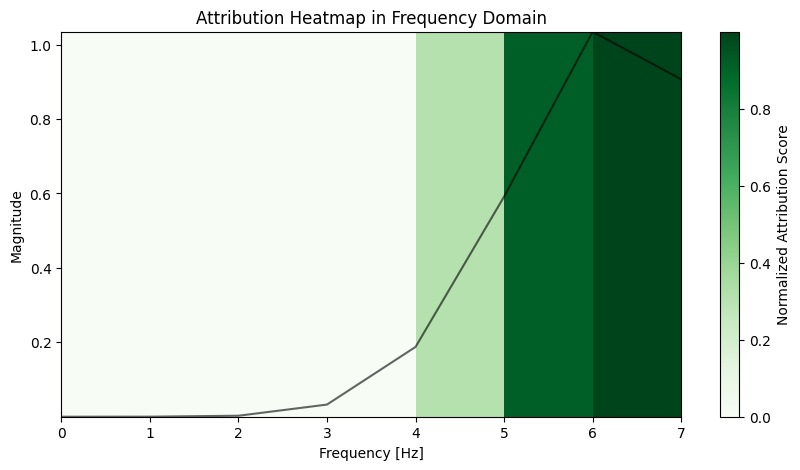

Prediction: 1, Label: 1


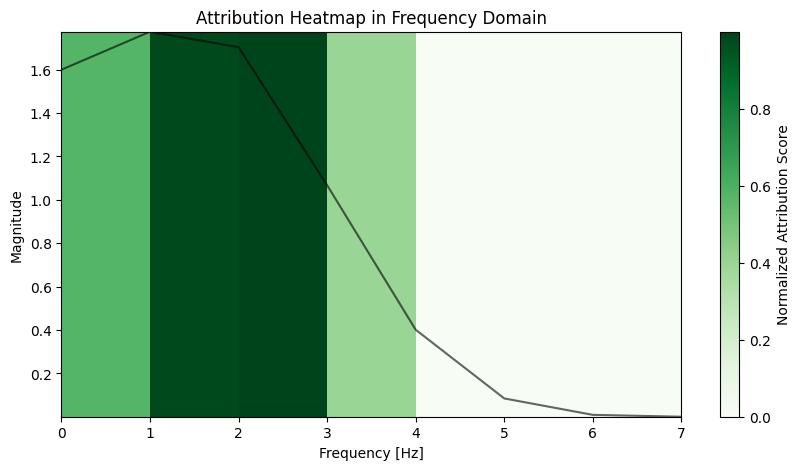

Prediction: 0, Label: 0


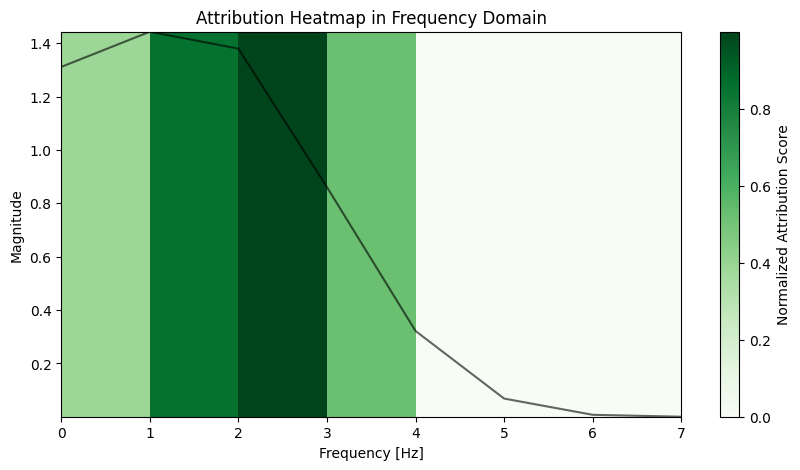

Prediction: 0, Label: 0


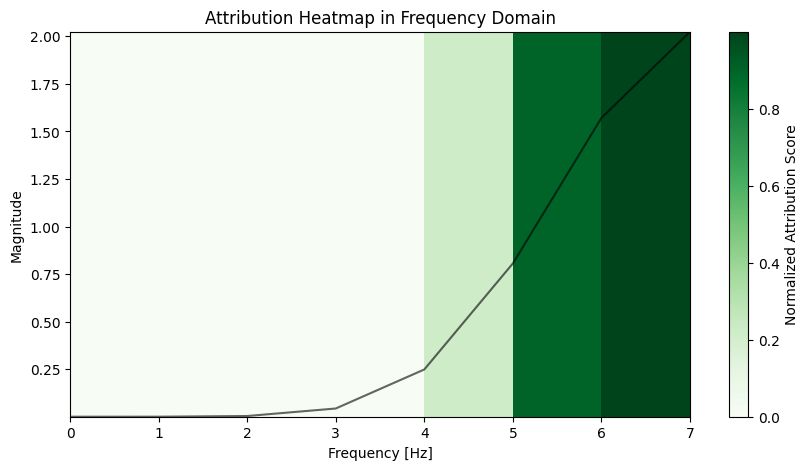

Prediction: 1, Label: 1


In [65]:
# show the mask avg for each class
counts = np.unique(labels, return_counts=True)
print(counts)


# plot the scores as a heatmap on the original signal
for x, y in test_loader:
    # get the first sequence
    x = x.numpy()

    print(len(attributions['filtermasks_flexime_64_9_128']))
    print(attributions['filtermasks_flexime_64_9_128'][0].shape)

    # plot 5 samples
    for i in range(1, 20):
        plot_freq_heatmap(x[i][0], attributions['filtermasks_flexime_64_9_128'][0][i], fs=fs)

        # print the prediction and the label of the sample
        print(f"Prediction: {predictions[i].argmax()}, Label: {labels[i]}")
    break

128
(64,)
(64,)


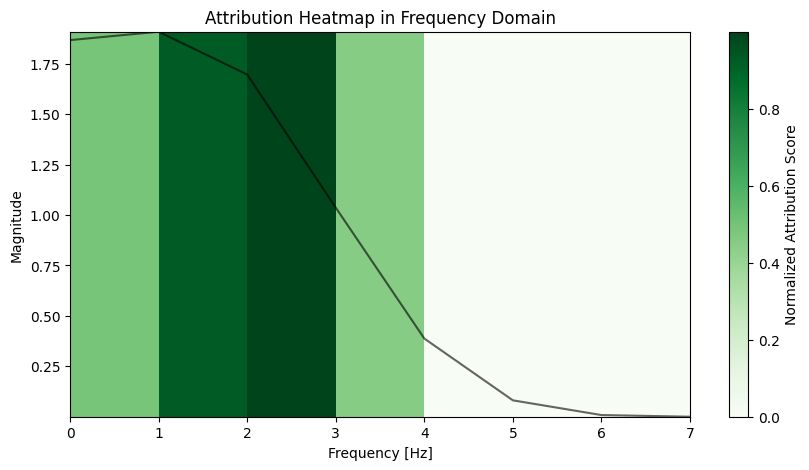

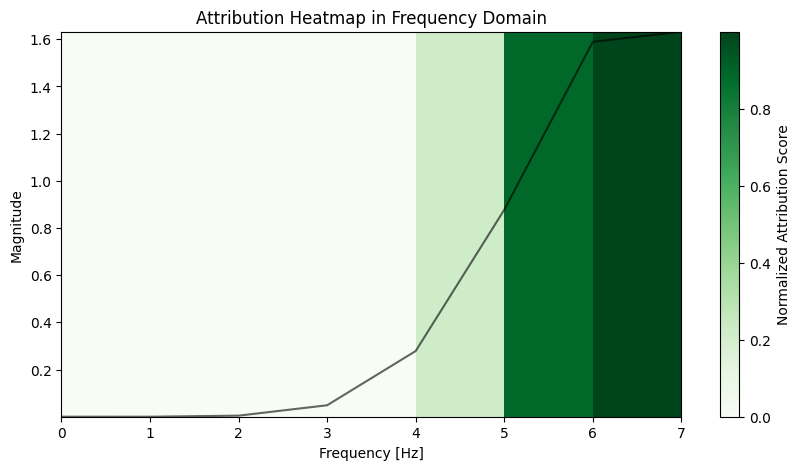

In [69]:
set_seed(42)

# average the masks for each class
masks_0 = np.zeros_like(attributions['filtermasks_flexime_64_9_128'][0][0])
masks_1 = np.zeros_like(attributions['filtermasks_flexime_64_9_128'][0][0])

print(len(attributions['filtermasks_flexime_64_9_128'][0]))

counts_0 = 0
counts_1 = 0

for i in range(len(attributions['filtermasks_flexime_64_9_128'][0])):
    if labels[i] == 0:
        masks_0 += attributions['filtermasks_flexime_64_9_128'][0][i]
        counts_0 += 1
    else:
        masks_1 += attributions['filtermasks_flexime_64_9_128'][0][i]
        counts_1 += 1
masks_0 /= counts_0
masks_1 /= counts_1
print(masks_0.shape)
print(masks_1.shape)

# plot the masks
plot_freq_heatmap(x[3][0], masks_0, fs=fs)
plot_freq_heatmap(x[i-4][0], masks_1, fs=fs)


In [70]:
def plot_scaleogram_fft_heatmap(signal, attribution, fs=1000):
    N = len(signal)
    freq = fftfreq(N, d=1/fs)
    len(freq)

    # Keep only positive frequencies
    pos_mask = freq >= 0
    freq = freq[pos_mask]

    time = np.linspace(0, len(signal) / fs, len(signal))

    # Normalize attribution scores to [0,1]
    attr_resized = np.interp(freq, np.linspace(freq.min(), freq.max(), len(attribution)), attribution)
    attr_norm = (attr_resized - np.min(attr_resized)) / (np.max(attr_resized) - np.min(attr_resized) + 1e-10)

    # Create a 2D grid for heatmap
    time_grid, freq_grid = np.meshgrid(time, freq)
    attr_grid = np.tile(attr_norm[:-1], (len(time) - 1, 1))  # Repeat attribution scores along the magnitude axis

    # Plot the scaleogram
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(time_grid, freq_grid, attr_grid.T, shading='auto', cmap='Greens')
    plt.colorbar(label="Normalized Attribution Score")
    plt.title('Attribution')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')

    plt.show()

79
(128, 64)


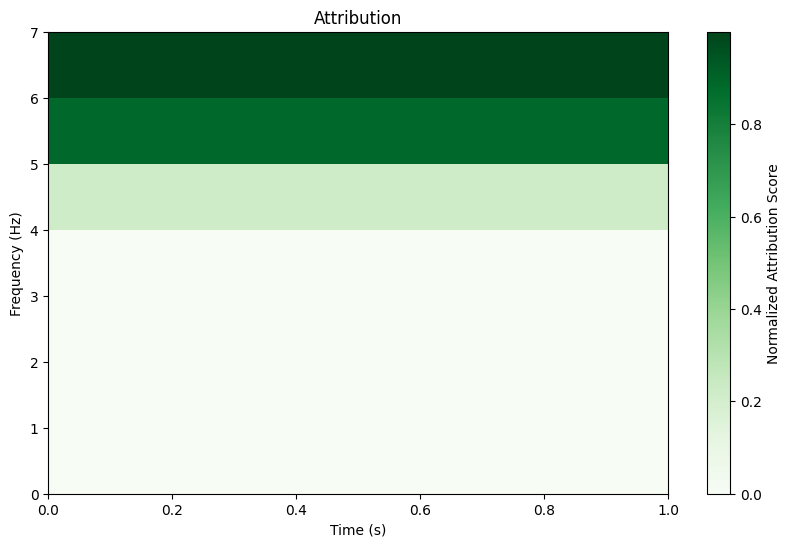

Prediction: 1, Label: 1


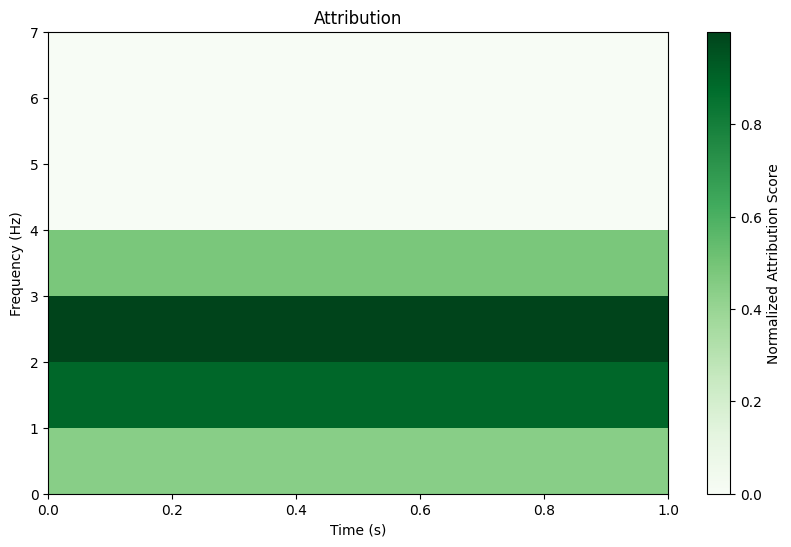

Prediction: 0, Label: 0


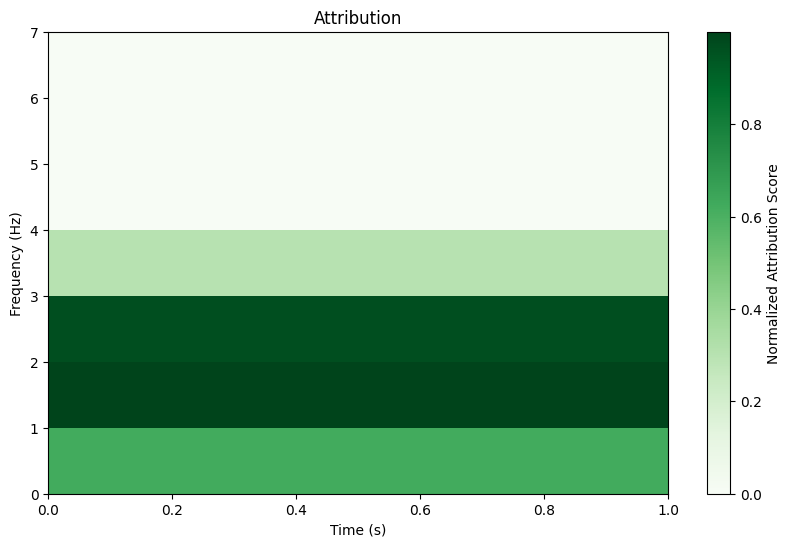

Prediction: 0, Label: 0


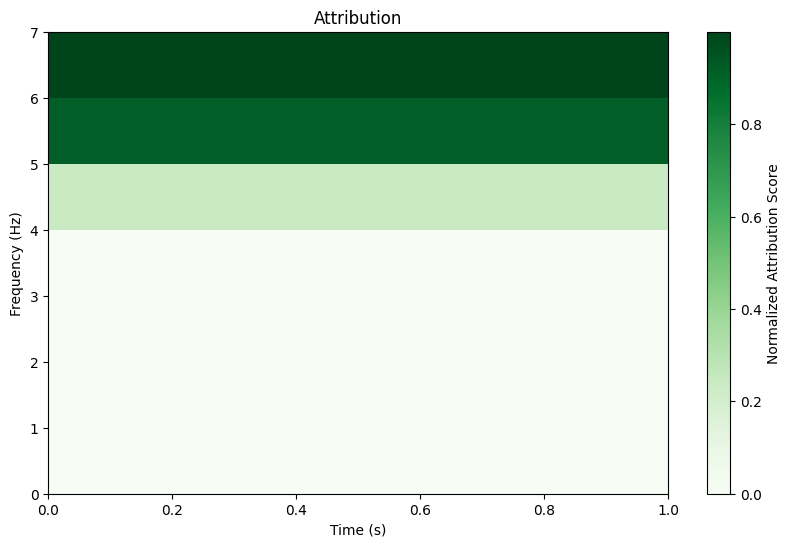

Prediction: 1, Label: 1


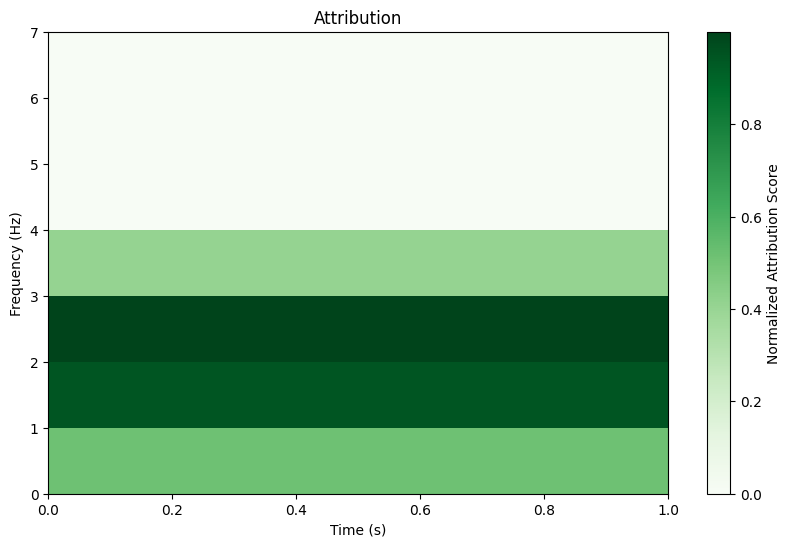

Prediction: 0, Label: 0


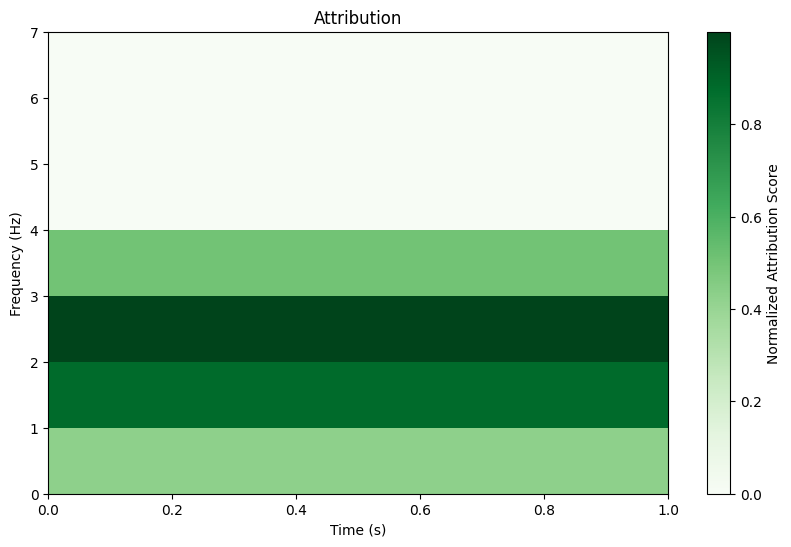

Prediction: 0, Label: 0


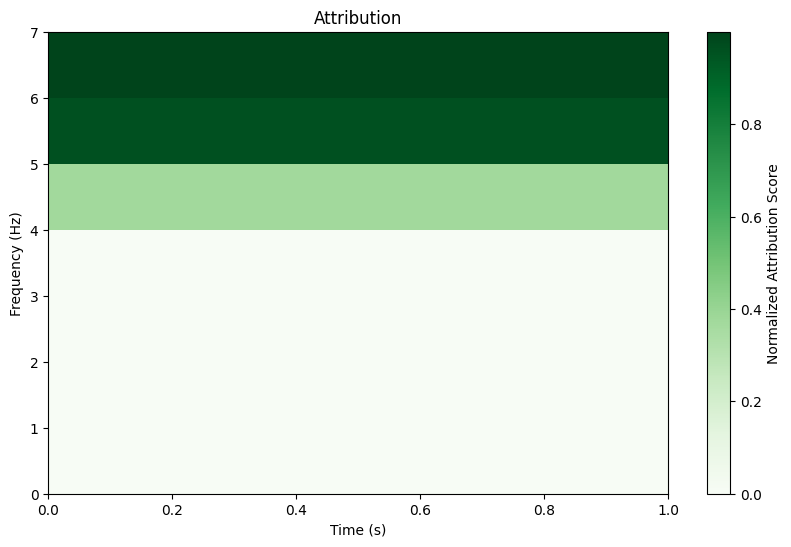

Prediction: 1, Label: 1


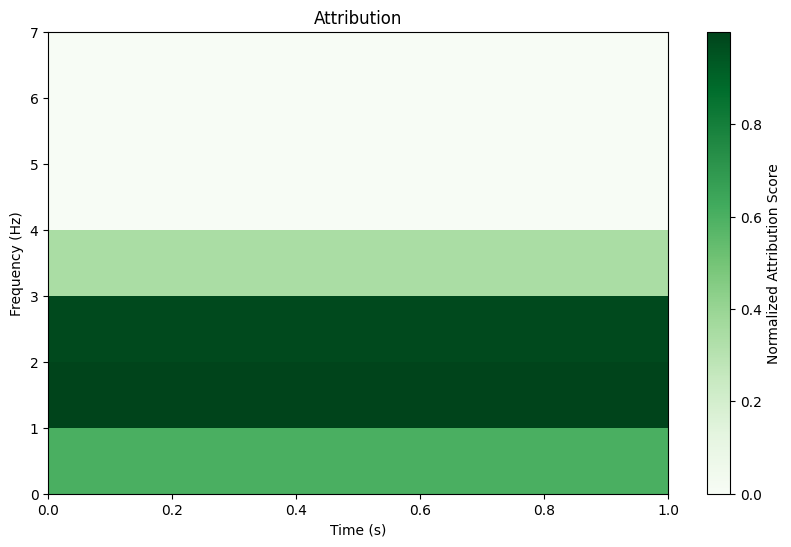

Prediction: 0, Label: 0


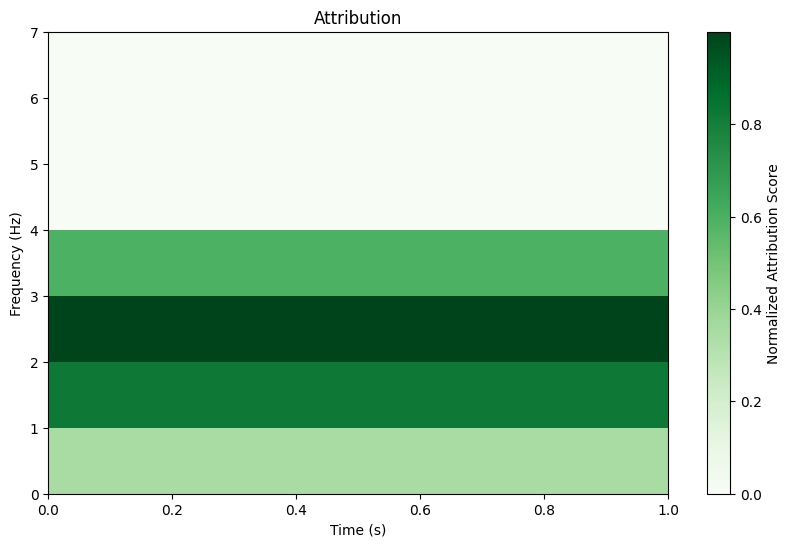

Prediction: 0, Label: 0


In [71]:
# plot the scores as a heatmap on the original signal
for x, y in test_loader:
    # get the first sequence
    x = x.numpy()

    print(len(attributions['filtermasks_flexime_64_9_128']))
    print(attributions['filtermasks_flexime_64_9_128'][0].shape)

    # plot 5 samples
    for i in range(1, 10):
        plot_scaleogram_fft_heatmap(x[i][0], attributions['filtermasks_flexime_64_9_128'][0][i], fs= fs)

        # print the prediction and the label of the sample
        print(f"Prediction: {predictions[i].argmax()}, Label: {labels[i]}")
    break

In [36]:
# generate a sinus signal
def generate_sinusoidal_signal(frequency, duration, fs):
    t = np.linspace(0, duration, int(fs * duration), endpoint=False)
    signal = np.sin(2 * np.pi * frequency * t)
    return signal

f = 10
duration = 1
fs = 1000
signal = generate_sinusoidal_signal(f, duration, fs)
print(signal.shape)

(1000,)


10
2
2
4
8
16
32
63
125
250
500


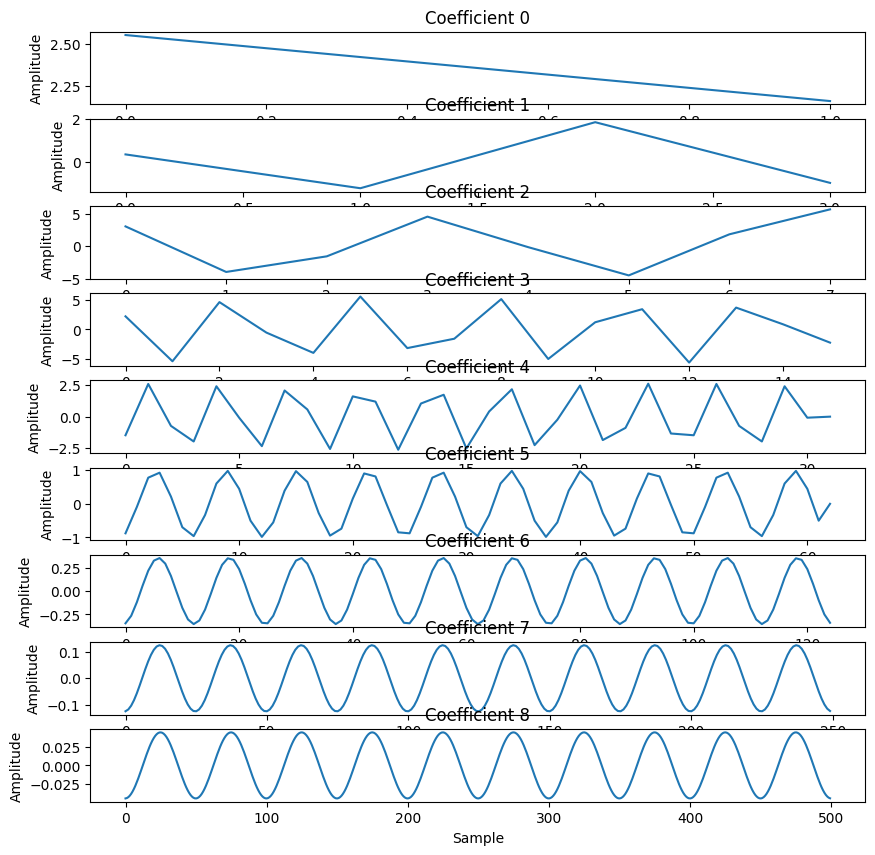

In [ ]:
coeffs = pywt.wavedec(signal, 'db1')
print(len(coeffs))

# remove not approx coeffs
coeffs = coeffs[1:]

for c in coeffs:
    print(len(c))


# plot the coeffs
fig, ax = plt.subplots(len(coeffs), figsize=(10, 10))
for i, coef in enumerate(coeffs):
    ax[i].plot(coef)
    ax[i].set_title(f'Coefficient {i}')
    ax[i].set_xlabel('Sample')
    ax[i].set_ylabel('Amplitude')

# bands = get_wavelet_bands(coeffs, signal)

# bands = bands[::-1]

# bands_downsampled = []
# for i, b in enumerate(bands):
#     if i == len(bands) - 1:
#         b = b[1::(2**(i))]
#     else:
#         b = b[1::(2**(i+1))]
#     print(len(b))
#     bands_downsampled.append(b)

# bands_downsampled = bands_downsampled[::-1]


In [79]:
test = [[1],[1,2],[1, 2, 3, 4],[1, 2, 3, 4, 5, 6, 7, 8]]

print(test)

for i, t in enumerate(test):
    print(t)
    print(len(t))

[[1], [1, 2], [1, 2, 3, 4], [1, 2, 3, 4, 5, 6, 7, 8]]
[1]
1
[1, 2]
2
[1, 2, 3, 4]
4
[1, 2, 3, 4, 5, 6, 7, 8]
8


In [80]:
def upsampling_wavedec(coeffs):
    """
    Upsample the coefficients of the wavelet transform to match the original signal length.
    """
    length = len(coeffs[-1]) * 2

    upsampled_coeffs = []
    for coeff in coeffs:
        factor = math.ceil(length/len(coeff))

        # Upsample coefficients to match the original signal length
        upsampled = np.repeat(coeff, factor)[:length]
        
        upsampled_coeffs.append(upsampled)
    return np.array(upsampled_coeffs)

In [81]:
upsampled_test = upsampling_wavedec(test)
print(upsampled_test)

[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2]
 [1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4]
 [1 1 2 2 3 3 4 4 5 5 6 6 7 7 8 8]]


In [82]:
def downsample_wavedec(coeffs):
    """
    Downsample the coefficients of the wavelet transform to match the original signal length.
    """
    coeffs = coeffs[::-1]

    downsampled_coeffs = []
    for i, coeff in enumerate(coeffs):
        c = coeff[1::(2**(i+1))]

        downsampled_coeffs.append(c)
    return downsampled_coeffs[::-1]

In [83]:
downsample_test = downsample_wavedec(upsampled_test)
print(downsample_test)

[array([1]), array([1, 2]), array([1, 2, 3, 4]), array([1, 2, 3, 4, 5, 6, 7, 8])]
